# Test longitudinal information status
Having affirmed the existence and volatility of named entities in Twitter streams ([here](test_longitudinal_data.ipynb)), we now look for longitudinal information status:

- Does change in information status lag change in frequency?
- Do larger named entities exhibit less volatility than smaller named entities?

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load data

In [2]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import process_status_txt_tag_files
import re
import pandas as pd
import numpy as np
tag_files = [
    # Maria
    '../../data/mined_tweets/archive_maria_txt_tags.gz', '../../data/mined_tweets/stream_maria_txt_tags.gz', '../../data/mined_tweets/historical_maria_txt_tags.gz',
    # Harvey
    '../../data/mined_tweets/archive_harvey_txt_tags.gz', '../../data/mined_tweets/stream_harvey_txt_tags.gz', '../../data/mined_tweets/historical_harvey_txt_tags.gz',
    # Irma
    '../../data/mined_tweets/archive_irma_txt_tags.gz', '../../data/mined_tweets/stream_irma_txt_tags.gz', '../../data/mined_tweets/historical_irma_txt_tags.gz',
    # Florence
    '../../data/mined_tweets/archive_florence_txt_tags.gz', '../../data/mined_tweets/east_coast_geo_twitter_2018/geo_stream_florence_txt_tags.gz', '../../data/mined_tweets/historical_florence_txt_tags.gz',
    # Michael
    '../../data/mined_tweets/archive_michael_txt_tags.gz', '../../data/mined_tweets/east_coast_geo_twitter_2018/geo_stream_michael_txt_tags.gz', '../../data/mined_tweets/historical_michael_txt_tags.gz',
]
combined_tag_data = []
for f in tag_files:
    f_combined = process_status_txt_tag_files(f)
    combined_tag_data.append(f_combined)
combined_tag_data = pd.concat(combined_tag_data, axis=0)
# remove nan data
combined_tag_data = combined_tag_data[~combined_tag_data.loc[:, 'id'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert date stamp to float for binning
combined_tag_data.loc[:, 'date_stamp'] = combined_tag_data.loc[:, 'date'].apply(lambda x: x.timestamp())
# get rid of duplicate statuses
combined_tag_data_N = combined_tag_data.shape[0]
combined_tag_data.drop_duplicates(['id', 'data_name_fixed'], inplace=True)
combined_tag_data.drop_duplicates(['txt', 'data_name_fixed'], inplace=True)
# get rid of hanging underscores!!
SPACE_UNDERSCORE_MATCHER = re.compile('[ _]+$')
combined_tag_data.loc[:, 'NE_list'] = combined_tag_data.loc[:, 'NE_list'].apply(lambda x: [[SPACE_UNDERSCORE_MATCHER.sub('', y[0]), y[1]] for y in x] if type(x) is list else [])
print('%d/%d deduplicated statuses'%(combined_tag_data.shape[0], combined_tag_data_N))

processing file archive_maria
processing file stream_maria
processing file historical_maria
processing file archive_harvey
processing file stream_harvey
processing file historical_harvey
processing file archive_irma
processing file stream_irma
processing file historical_irma
processing file archive_florence
processing file geo_stream_florence
processing file historical_florence
processing file archive_michael
processing file geo_stream_michael
processing file historical_michael
1921012/4106088 deduplicated statuses


In [3]:
# clean tag types
combined_tag_data.loc[:, 'NE_list'] = combined_tag_data.loc[:, 'NE_list'].apply(lambda x: [(y[0], y[1].replace('"', '')) for y in x])
# unify tag types: "geo-loc" => "LOCATION", etc.
NE_type_lookup = {'geo' : 'LOCATION', 'person':'PERSON'}
combined_tag_data.loc[:, 'NE_list'] = combined_tag_data.loc[:, 'NE_list'].apply(lambda x: [(y[0], NE_type_lookup[y[1]]) if y[1] in NE_type_lookup else y for y in x])

Filter for locations.

In [4]:
LOC_TYPES = ['CITY', 'LOCATION']
combined_tag_data.loc[:, 'NE_list_LOC'] = combined_tag_data.loc[:, 'NE_list'].apply(lambda x: [y for y in x if y[1] in LOC_TYPES])
display(combined_tag_data.head())

,id,username,date,retweets,favorites,lang,txt,NE_list,data_name,data_name_fixed,date_stamp,NE_list_LOC
0,914030327777067008,EmeraidKatNJ,2017-09-30 07:33:06+00:00,0,0,en,RT @chefjoseandres: Quick update from #PuertoR...,[],archive_maria,maria,1.506757e+09,[]
1,914031326042435584,X_RATED25,2017-09-30 07:37:04+00:00,0,0,en,#Support #Purchase @X_RATED25 Single (#DontHa...,[],archive_maria,maria,1.506757e+09,[]
2,914031644784431110,D_McCaughan,2017-09-30 07:38:20+00:00,0,0,en,RT @Scavino45: POTUS' @realDonaldTrump on Hurr...,"[(POTUS, PERSON), (Hurricane, LOCATION)]",archive_maria,maria,1.506757e+09,"[(Hurricane, LOCATION)]"
3,914031795787763713,eccolabella,2017-09-30 07:38:56+00:00,0,0,en,RT @altNOAA: .@realDonaldTrump If you can't ge...,[],archive_maria,maria,1.506757e+09,[]
4,914032227817836544,CorinaRey,2017-09-30 07:40:39+00:00,0,0,en,RT @altNOAA: According to #PuertoRico governme...,[],archive_maria,maria,1.506757e+09,[]


What is the distribution of `LOCATION` entities?

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import SpaceTokenizer
NER_TKNZR = SpaceTokenizer()
SPACE_FIXER = re.compile('\s{2,}|\s+$|^\s+')
for data_name_i, data_i in combined_tag_data.groupby('data_name_fixed'):
    print('processing data %s'%(data_name_i))
    cv = CountVectorizer(min_df=1, ngram_range=(1,1), tokenizer=NER_TKNZR.tokenize, stop_words=[''])
    LOC_txt = data_i.loc[:, 'NE_list_LOC'].apply(lambda x: ' '.join([y[0].lower().strip() for y in x]))
#     print('problem txt')
#     print(LOC_txt[LOC_txt.apply(lambda x: UNDERSCORE_SPACE_MATCHER.search(x) is not None)])
#     break
    dtm = cv.fit_transform(LOC_txt)
    LOC_counts = np.array(dtm.sum(axis=0))[0]
    LOC_counts = pd.Series(LOC_counts, index=[x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x: x[0])])
    LOC_counts.sort_values(inplace=True, ascending=False)
    print(LOC_counts.head(100))

processing data florence
north_carolina         3656
nc                     3305
#florence              3100
wilmington             1289
south_carolina         1125
sc                      990
florence                893
carolina                556
new_bern                441
cape_fear_river         312
virginia                301
myrtle_beach            298
raleigh                 273
fayetteville            255
carolinas               248
charlotte               239
lumberton               204
conway                  161
charleston              142
wrightsville_beach      132
jacksonville            124
italy                   121
puerto_rico             113
durham                  107
morehead_city           106
florida                 103
georgia                 101
horry_county             98
richmond                 97
america                  93
                       ... 
hurricane_florence       35
ga                       35
duplin_county            35
inland                 

It seems like there's a variety of large and small locations.

### Test for descriptors
How often is a location followed by a descriptor?

Let's flatten the data to make this a bit easier.

In [ ]:
combined_tag_data_NE_flat = []
flat_rows = ['id', 'txt', 'data_name_fixed']
NE_ctr = 0
tweet_ctr = 0
for idx_i, data_i in combined_tag_data.iterrows():
    for NE in data_i.loc['NE_list_LOC']:
        data_j = data_i.loc[flat_rows]
        data_j.loc['NE'] = NE
        combined_tag_data_NE_flat.append(data_j)
        NE_ctr += 1
        if(NE_ctr % 1000 == 0):
            print('processed %d NEs, %d/%d tweets'%(NE_ctr, tweet_ctr, combined_tag_data.shape[0]))
    tweet_ctr += 1
combined_tag_data_NE_flat = pd.concat(combined_tag_data_NE_flat, axis=1).transpose()
combined_tag_data_NE_flat.columns = flat_rows + ['NE']
print('%d NEs total'%(combined_tag_data_NE_flat.shape[0]))

processed 1000 NEs, 7092/1921012 tweets
processed 2000 NEs, 13115/1921012 tweets
processed 3000 NEs, 16215/1921012 tweets
processed 4000 NEs, 21625/1921012 tweets
processed 5000 NEs, 27858/1921012 tweets
processed 6000 NEs, 32917/1921012 tweets
processed 7000 NEs, 38006/1921012 tweets
processed 8000 NEs, 42497/1921012 tweets
processed 9000 NEs, 46478/1921012 tweets
processed 10000 NEs, 50353/1921012 tweets
processed 11000 NEs, 54178/1921012 tweets
processed 12000 NEs, 58183/1921012 tweets
processed 13000 NEs, 61832/1921012 tweets
processed 14000 NEs, 65185/1921012 tweets
processed 15000 NEs, 69153/1921012 tweets
processed 16000 NEs, 73348/1921012 tweets
processed 17000 NEs, 77368/1921012 tweets
processed 18000 NEs, 81677/1921012 tweets
processed 19000 NEs, 86603/1921012 tweets
processed 20000 NEs, 91540/1921012 tweets
processed 21000 NEs, 96850/1921012 tweets
processed 22000 NEs, 102296/1921012 tweets
processed 23000 NEs, 108749/1921012 tweets
processed 24000 NEs, 114454/1921012 tweets

Let's try to be careful about extracting descriptors. We don't want to waste time with a bunch of location duds.

1. Check if location is valid (in GeoNames + within bounding box of a given disaster).
2. Look for descriptor.

First, load GeoNames data and regexes for name matching.

In [66]:
import re
from unidecode import unidecode
geonames_name_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False, usecols=['name', 'alternate_names', 'feature_code', 'country', 'latitude', 'longitude', 'population'])
geonames_name_data.fillna('', inplace=True)
display(geonames_name_data.head())
# restrict to certain LOC types
loc_feat_codes = set(['PPL', 'PPLA', 'PPLA2', 'ADM1', 'ADM2', 'ADM3', 'ADM4', 'PPLL', 'PPLS', 'PPLG', 'PPLC', 'PPLX', 'SCH', 'CH', 'BLDG', 'CMTY', 'LCTY', 'ISL'])
geonames_name_data_loc = geonames_name_data[geonames_name_data.loc[:, 'feature_code'].isin(loc_feat_codes)]
# restrict to US 
geonames_countries = ['US', 'PR']
geonames_name_data_loc = geonames_name_data_loc[geonames_name_data_loc.loc[:, 'country'].isin(geonames_countries)]
# match each location name to GeoNames entry
# using regex of alternate names
name_affixes = ['county$', 'city$', 'district$', '^fort']
name_affix_matcher = re.compile('|'.join(name_affixes))
def build_name_regex(x):
    try:
        x_regex_set = set([x.loc['name']]+str(x.loc['alternate_names']).split(',')) - set([''])
        x_regex_set.add(name_affix_matcher.sub('', x.loc['name'].lower()).strip())
        x_regex = re.compile('|'.join(['^%s$'%(y.lower()) for y in x_regex_set]))
    except Exception as e:
        x_regex = ''
    return x_regex
geonames_name_data_loc.loc[:, 'name_regex'] = geonames_name_data_loc.apply(lambda x: build_name_regex(x), axis=1)
geonames_name_data_loc = geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex'] != '']
print('%d valid GeoNames locations'%(geonames_name_data_loc.shape[0]))

,name,alternate_names,latitude,longitude,feature_code,country,population
0,Pic de Font Blanca,"Pic de Font Blanca,Pic du Port",42.64991,1.53335,PK,AD,0
1,Roc Mélé,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74028,MT,AD,0
2,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,PK,AD,0
3,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,PK,AD,0
4,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,LK,AD,0


948807 valid GeoNames locations


In [67]:
# get common affixes for removal
geonames_name_data_pop = geonames_name_data[geonames_name_data.loc[:, 'population'] > np.percentile(geonames_name_data.loc[:, 'population'], 50)]
prefix_counts = geonames_name_data_pop.loc[:, 'name'].apply(lambda x: x.lower().split(' ')[0]).value_counts()
suffix_counts = geonames_name_data_pop.loc[:, 'name'].apply(lambda x: x.lower().split(' ')[-1]).value_counts()
print('top prefixes')
print(prefix_counts.head(20))
print('top suffixes')
print(suffix_counts.head(20))

top prefixes
el         20633
la         17291
san        12094
city        8567
town        7842
los         5535
las         4772
santa       4250
al          4145
village     3764
rancho      3345
colonia     1901
le          1900
borough     1243
case        1127
loma         895
villa        877
amphoe       876
agua         807
cerro        786
Name: name, dtype: int64
top suffixes
county       3044
city         1116
grande        789
district      696
i̇lçesi       690
park          633
cruz          567
ii            537
i             530
village       523
blanca        523
nuevo         492
esperanza     483
hill          481
lake          477
guadalupe     473
antonio       444
verde         427
shi           427
springs       424
Name: name, dtype: int64


In [ ]:
# look up each unique name once! 
# then just use a dict
combined_tag_data_NE_flat_names = combined_tag_data_NE_flat.loc[:, 'NE'].apply(lambda x: unidecode(x[0].lower()).replace('_', ' ')).unique()
print('%d unique names'%(len(combined_tag_data_NE_flat_names)))
# get dict of name : geoname data
geo_dict = {x: geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex'].apply(lambda y: y.search(x) is not None)] for x in combined_tag_data_NE_flat_names}

19259 unique names


In [71]:
print('%d geo dict entries'%(len(geo_dict)))

19259 geo dict entries


In [72]:
test_NE = 'lauderdale'
display(geo_dict[test_NE])

,name,alternate_names,latitude,longitude,feature_code,country,population,name_regex
9082731,Lauderdale County,"Comitatul Lauderdale,Comte de Lauderdale,Comté...",34.90137,-87.65400,ADM2,US,92709,"re.compile(""^shhrstan lawdrdyl alabama$|^lodu..."
9166399,Fort Lauderdale,"FLL,Fort Lauderdale,Fort Loderdeil,Fort Loderd...",26.12231,-80.14338,PPLA2,US,178590,"re.compile(""^pharta la'udaradela$|^phorta loda..."
9172038,Lauderdale-by-the-Sea,"Lauderdale,Lauderdale by the sea",26.19203,-80.09643,PPL,US,6460,re.compile('^lauderdale-by-the-sea$|^lauderdal...
9340316,Lauderdale,,30.48131,-92.77515,PPL,US,0,re.compile('^lauderdale$|^lauderdale$')
9340317,Lauderdale,"Lauderdale,Lauderdale Plantation",30.08631,-90.91454,PPL,US,0,re.compile('^lauderdale$|^lauderdale$|^lauderd...
9442330,Lauderdale,"Lauderdale,Lauderdale Station,Spring Depot",32.52069,-88.51170,PPL,US,442,re.compile('^lauderdale$|^lauderdale$|^spring ...
9442333,Lauderdale County,"Comitatul Lauderdale,Comte de Lauderdale,Comté...",32.40429,-88.66254,ADM2,US,80261,"re.compile(""^lodurdejl$|^شهرستان لاودردیل، میس..."
9637552,Lauderdale County,"Comitatul Lauderdale,Comte de Lauderdale,Comté...",35.76101,-89.63144,ADM2,US,27815,"re.compile(""^lodurdejl$|^lauderdale kūn$|^cond..."
10032422,Lauderdale,"City of Lauderdale,Lauderdale",44.99858,-93.20578,PPL,US,2506,re.compile('^lauderdale$|^city of lauderdale$|...
10256801,Lauderdale,,42.76529,-88.55566,PPL,US,0,re.compile('^lauderdale$|^lauderdale$')


In [73]:
state_codes = set(['ADM1'])
territory_codes = set(['PCLD'])
country_code = 'PCLI'
us_countries = set(['US'])
us_territory_countries = set(['US', 'PR'])
geonames_country_state = geonames_name_data[((geonames_name_data.loc[:, 'feature_code'].isin(state_codes)) & (geonames_name_data.loc[:, 'country'].isin(us_countries))) | 
                                            ((geonames_name_data.loc[:, 'feature_code'].isin(territory_codes)) & (geonames_name_data.loc[:, 'country'].isin(us_territory_countries))) |
                                            (geonames_name_data.loc[:, 'feature_code'] == country_code)]
geonames_country_state.loc[:, 'name_regex'] = geonames_country_state.apply(build_name_regex, axis=1)
print('%d country/state names'%(geonames_country_state.shape[0]))
display(geonames_country_state.head())

245 country/state names


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,name,alternate_names,latitude,longitude,feature_code,country,population,name_regex
2746,Principality of Andorra,"'Enitola,213,Andora,Andore,Andoro,Andorra,Ando...",42.55,1.58333,PCLI,AD,84000,"re.compile(""^andurra$|^آندورا$|^orileede aando..."
3420,United Arab Emirates,"'Alepea Fakatahataha,A-la-baik Lieng-hak Dai-g...",23.75,54.50000,PCLI,AE,4975593,re.compile('^холбоhуктаах араб эмираттара$|^sa...
38023,Islamic Republic of Afghanistan,"'Afikanisitani,'Apekanikana,A Phu Han (Afghani...",33.00,66.00000,PCLI,AF,29121286,re.compile('^republica de l\'afganistan$|^afga...
85465,Antigua and Barbuda,"Aintige agus Barbuda,Aintíge agus Barbúda,An-t...",17.05,-61.80000,PCLI,AG,86754,"re.compile(""^antigua ha barbuda$|^antigua et b..."
88716,Republic of Albania,"'Alipania,Al'banija,Albaani,Albaania,Albaaniya...",41.00,20.00000,PCLI,AL,2986952,"re.compile(""^alubaniya$|^albaania$|^a er ba ni..."


In [74]:
DATA_LOC_BOXES = {
    'florence' : [[31.0,36.6], [-85.0,-76.6]],
    'harvey' : [[26.7,36.3], [-105.1,-89.9]],
    'irma' : [[25.5,34.4], [-88.1,-79.0]],
    'maria' : [[17.8,18.5], [-67.4,-65.1]],
    'michael' : [[24.7,34.9], [-88.3,-75.3]],
}
def allow_loc_bound(x, geo_dict, geonames_country_state, verbose=False):
    x_data_name = x.loc['data_name_fixed']
    (lat1, lat2), (lon1, lon2) = DATA_LOC_BOXES[x_data_name]
    x_txt_clean = unidecode(x.loc['NE'][0].replace('_', ' ').lower())
    has_ref = geo_dict.get(x_txt_clean) is not None and geo_dict[x_txt_clean].shape[0] > 0
    # if has_ref, check for bounding box
    if(has_ref):
        geo_data = geo_dict[x_txt_clean]
        geo_data_in_box = geo_data[(geo_data.loc[:, 'latitude'] >= lat1) &
                                   (geo_data.loc[:, 'latitude'] <= lat2) &
                                   (geo_data.loc[:, 'longitude'] >= lon1) &
                                   (geo_data.loc[:, 'longitude'] <= lon2)]
        has_bound_ref = geo_data_in_box.shape[0] > 0
    else:
        has_bound_ref = False
    not_country_state = geonames_country_state[geonames_country_state.loc[:, 'name_regex'].apply(lambda y: y.search(x_txt_clean) is not None)].shape[0] == 0
    if(verbose):
        print('%s has ref %s bound_ref %s not_country_state %s'%(x_txt_clean, has_ref, has_bound_ref, not_country_state))
    return has_ref and has_bound_ref and not_country_state

In [75]:
x_data_test_1 = pd.Series([('San_Juan', 'LOCATION'), 'maria'], index=['NE', 'data_name_fixed'])
x_data_test_2 = pd.Series([('Houston', 'LOCATION'), 'harvey'], index=['NE', 'data_name_fixed'])
x_data_test_3 = pd.Series([('Houston', 'LOCATION'), 'maria'], index=['NE', 'data_name_fixed'])
x_data_test_4 = pd.Series([('Puerto_Rico', 'LOCATION'), 'maria'], index=['NE', 'data_name_fixed'])
x_data_test_5 = pd.Series([('Manhattan', 'LOCATION'), 'harvey'], index=['NE', 'data_name_fixed'])
print(allow_loc_bound(x_data_test_1, geo_dict, geonames_country_state, verbose=True))
print(allow_loc_bound(x_data_test_2, geo_dict, geonames_country_state, verbose=True))
print(allow_loc_bound(x_data_test_3, geo_dict, geonames_country_state, verbose=True))
print(allow_loc_bound(x_data_test_4, geo_dict, geonames_country_state, verbose=True))
print(allow_loc_bound(x_data_test_5, geo_dict, geonames_country_state, verbose=True))

san juan has ref True bound_ref True not_country_state True
True
houston has ref True bound_ref True not_country_state True
True
houston has ref True bound_ref False not_country_state True
False
puerto rico has ref True bound_ref True not_country_state False
False
manhattan has ref True bound_ref True not_country_state True
True


In [76]:
combined_tag_data_NE_flat_valid = []
for i, (idx_i, data_i) in enumerate(combined_tag_data_NE_flat.iterrows()):
    allow_data_i = allow_loc_bound(data_i, geo_dict, geonames_country_state, verbose=False)
    combined_tag_data_NE_flat_valid.append(allow_data_i)
    if(i % 10000 == 0):
        print('processed %d NEs'%(i))
combined_tag_data_NE_flat.loc[:, 'valid_loc'] = combined_tag_data_NE_flat_valid
print('%d/%d valid locations'%(combined_tag_data_NE_flat.loc[:, 'valid_loc'].sum(), combined_tag_data_NE_flat.shape[0]))

processed 0 NEs
processed 10000 NEs
processed 20000 NEs
processed 30000 NEs
processed 40000 NEs
processed 50000 NEs
processed 60000 NEs
processed 70000 NEs
processed 80000 NEs
processed 90000 NEs
processed 100000 NEs
processed 110000 NEs
processed 120000 NEs
processed 130000 NEs
processed 140000 NEs
processed 150000 NEs
processed 160000 NEs
processed 170000 NEs
processed 180000 NEs
processed 190000 NEs
processed 200000 NEs
processed 210000 NEs
processed 220000 NEs
processed 230000 NEs
processed 240000 NEs
processed 250000 NEs
processed 260000 NEs
processed 270000 NEs
processed 280000 NEs
processed 290000 NEs
processed 300000 NEs
processed 310000 NEs
processed 320000 NEs
processed 330000 NEs
processed 340000 NEs
processed 350000 NEs
processed 360000 NEs
processed 370000 NEs
processed 380000 NEs
processed 390000 NEs
processed 400000 NEs
processed 410000 NEs
processed 420000 NEs
processed 430000 NEs
processed 440000 NEs
processed 450000 NEs
processed 460000 NEs
processed 470000 NEs
proces

In [77]:
## TODO: parallel? otherwise we're stuck in regex hell
STATES_SHORT_FULL_LOOKUP = {
    'FL' : 'Florida', 'NC' : 'North Carolina', 'SC' : 'South Carolina', 
    'VA' : 'Virginia', 'GA' : 'Georgia', 'PR' : 'Puerto Rico',
    'LA' : 'Louisiana', 'TX' : 'Texas',
    
}
DATA_NAME_STATES_SHORT_LOOKUP = {
    'florence' : ['FL', 'NC', 'SC', 'VA'],
    'irma' : ['FL', 'GA'],
    'harvey' : ['TX', 'LA'],
    'maria' : ['PR', 'NC'],
    'michael' : ['FL', 'GA', 'NC', 'SC']
}
DATA_NAME_STATES_LONG_LOOKUP = {k : [STATES_SHORT_FULL_LOOKUP[v] for v in vs] for k, vs in DATA_NAME_STATES_SHORT_LOOKUP.items()}
DATA_NAME_STATES_LOOKUP = {k : DATA_NAME_STATES_SHORT_LOOKUP[k]+DATA_NAME_STATES_LONG_LOOKUP[k] for k in DATA_NAME_STATES_SHORT_LOOKUP.keys()}
# STATES_SHORT = ['PR', 'FL', 'TX', 'NC', 'SC', 'GA']
# STATES_FULL = ['Puerto Rico', 'Florida', 'Texas', 'North Carolina', 'South Carolina', 'Georgia']
# STATE_NAMES = STATES_SHORT + STATES_FULL
# DESCRIPTOR_SPACE_MATCHER = '|'.join(['(?=, %s)'%('%s', x.lower()) for x in STATE_NAMES])
# DESCRIPTOR_NE_MATCHER = re.compile('|'.join(',_%s'%(x.lower()) for x in STATE_NAMES))
def find_descriptor(data, verbose=False):
    data_NE = data.loc['NE'][0].replace('_', ' ').lower()
    if(verbose):
        print('testing NE %s'%(data_NE))
    data_name = data.loc['data_name_fixed']
    data_name_states = DATA_NAME_STATES_LOOKUP[data_name]
    try:
        data_NE_txt_matcher = re.compile('|'.join(['%s[, ]\s?%s'%(data_NE, x.lower()) for x in data_name_states]))
    except Exception as e:
        print('bad pattern %s'%('|'.join(['%s[, ]\s?%s'%(data_NE, x.lower()) for x in data_name_states])))
        data_NE_txt_matcher = re.compile('<NULL>')
    try:
        data_NE_matcher = re.compile('|'.join(['[, ]\s?%s'%(x.lower()) for x in data_name_states]))
    except Exception as e:
        print('bad pattern %s'%('|'.join(['%s[, ]\s?%s'%(data_NE, x.lower()) for x in data_name_states])))
        data_NE_matcher = re.compile('<NULL>')
    data_txt = data.loc['txt'].lower()
    
    data_NE_txt_descriptor = data_NE_txt_matcher.search(data_txt) is not None
    data_NE_descriptor = data_NE_matcher.search(data_NE) is not None
    if(verbose):
        print('data NE txt pattern %s'%(data_NE_txt_matcher.pattern))
        print('data NE pattern %s'%(data_NE_matcher.pattern))
        print('data NE txt %s'%(data_NE_txt_descriptor))
        print('data NE %s'%(data_NE_descriptor))
    data_descriptor = data_NE_descriptor or data_NE_txt_descriptor
    return data_descriptor
# test descriptor extraction
test_data_1 = pd.Series(['Houston, TX', ('Houston', 'LOCATION'), 'harvey'], index=['txt', 'NE', 'data_name_fixed'])
test_data_2 = pd.Series(['Houston, TX', ('Houston,_TX', 'LOCATION'), 'harvey'], index=['txt', 'NE', 'data_name_fixed'])
test_data_3 = pd.Series(['in San Juan, PR', ('San_Juan', 'LOCATION'), 'maria'], index=['txt', 'NE', 'data_name_fixed'])
test_data_4 = pd.Series(['in San Juan, TX', ('San_Juan', 'LOCATION'), 'maria'], index=['txt', 'NE', 'data_name_fixed'])
print(find_descriptor(test_data_1, verbose=True))
print(find_descriptor(test_data_2, verbose=True))
print(find_descriptor(test_data_3, verbose=True))
print(find_descriptor(test_data_4, verbose=True))

testing NE houston
data NE txt pattern houston[, ]\s?tx|houston[, ]\s?la|houston[, ]\s?texas|houston[, ]\s?louisiana
data NE pattern [, ]\s?tx|[, ]\s?la|[, ]\s?texas|[, ]\s?louisiana
data NE txt True
data NE False
True
testing NE houston, tx
data NE txt pattern houston, tx[, ]\s?tx|houston, tx[, ]\s?la|houston, tx[, ]\s?texas|houston, tx[, ]\s?louisiana
data NE pattern [, ]\s?tx|[, ]\s?la|[, ]\s?texas|[, ]\s?louisiana
data NE txt False
data NE True
True
testing NE san juan
data NE txt pattern san juan[, ]\s?pr|san juan[, ]\s?nc|san juan[, ]\s?puerto rico|san juan[, ]\s?north carolina
data NE pattern [, ]\s?pr|[, ]\s?nc|[, ]\s?puerto rico|[, ]\s?north carolina
data NE txt True
data NE False
True
testing NE san juan
data NE txt pattern san juan[, ]\s?pr|san juan[, ]\s?nc|san juan[, ]\s?puerto rico|san juan[, ]\s?north carolina
data NE pattern [, ]\s?pr|[, ]\s?nc|[, ]\s?puerto rico|[, ]\s?north carolina
data NE txt False
data NE False
False


In [78]:
%%capture descriptor_output
combined_tag_data_NE_flat_has_descriptor = []
descriptor_ctr = 0
for idx_i, data_i in combined_tag_data_NE_flat.iterrows():
    data_i_has_descriptor = find_descriptor(data_i, verbose=False)
    combined_tag_data_NE_flat_has_descriptor.append(data_i_has_descriptor)
    if(descriptor_ctr % 1000 == 0):
        print('processed %d NEs'%(descriptor_ctr))
    descriptor_ctr += 1
combined_tag_data_NE_flat.loc[:, 'has_descriptor'] = combined_tag_data_NE_flat_has_descriptor
print('%d/%d NEs have standard descriptor'%(combined_tag_data_NE_flat.loc[:, 'has_descriptor'].astype(int).sum(), combined_tag_data_NE_flat.shape[0]))

In [79]:
descriptor_output.show()

processed 0 NEs
processed 1000 NEs
processed 2000 NEs
processed 3000 NEs
processed 4000 NEs
processed 5000 NEs
processed 6000 NEs
processed 7000 NEs
processed 8000 NEs
processed 9000 NEs
processed 10000 NEs
processed 11000 NEs
processed 12000 NEs
processed 13000 NEs
processed 14000 NEs
processed 15000 NEs
processed 16000 NEs
processed 17000 NEs
processed 18000 NEs
processed 19000 NEs
processed 20000 NEs
processed 21000 NEs
processed 22000 NEs
processed 23000 NEs
processed 24000 NEs
processed 25000 NEs
processed 26000 NEs
processed 27000 NEs
processed 28000 NEs
processed 29000 NEs
processed 30000 NEs
processed 31000 NEs
bad pattern ponce ) 1950[, ]\s?pr|ponce ) 1950[, ]\s?nc|ponce ) 1950[, ]\s?puerto rico|ponce ) 1950[, ]\s?north carolina
processed 32000 NEs
processed 33000 NEs
processed 34000 NEs
processed 35000 NEs
processed 36000 NEs
processed 37000 NEs
processed 38000 NEs
processed 39000 NEs
processed 40000 NEs
processed 41000 NEs
processed 42000 NEs
processed 43000 NEs
processed 44

In [80]:
# valid loc + standard descriptor
NE_valid_loc = combined_tag_data_NE_flat[combined_tag_data_NE_flat.loc[:, 'valid_loc']]
print('%d/%d valid NE locations'%(NE_valid_loc.shape[0], combined_tag_data_NE_flat.shape[0]))
NE_valid_loc_descriptor = combined_tag_data_NE_flat[(combined_tag_data_NE_flat.loc[:, 'has_descriptor']) & (combined_tag_data_NE_flat.loc[:, 'valid_loc'])]
print('%d/%d NEs are valid and have standard descriptor'%(NE_valid_loc_descriptor.shape[0], combined_tag_data_NE_flat.shape[0]))
# unique NEs with/without descriptor
NE_valid_loc.loc[:, 'NE_name'] = NE_valid_loc.loc[:, 'NE'].apply(lambda x: x[0])
NE_valid_loc_counts_ne = NE_valid_loc.loc[:, 'NE_name'].value_counts()
print(NE_valid_loc_counts_ne.head(20))

167228/521817 valid NE locations
17135/521817 NEs are valid and have standard descriptor


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


Houston           38583
Miami             12757
Tampa              4656
Naples             4081
San_Juan           3717
Corpus_Christi     3525
Orlando            3304
Rockport           2889
Austin             1812
Atlanta            1766
Marco_Island       1539
Panama_City        1505
Jacksonville       1476
Dallas             1400
San_Antonio        1318
Wilmington         1315
Mexico_Beach       1202
Galveston          1119
Miami_Beach        1063
Charleston         1030
Name: NE_name, dtype: int64


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


This isn't great but it could still be enough to tell a story at the macro level.

In [81]:
# save for posterity
combined_tag_data_NE_flat.to_csv('../../data/mined_tweets/combined_tweet_NE_flat_data_1.tsv', sep='\t', index=False)

## Test NE tagging precision
Let's test how many of the tagged LOCATION NEs are correctly tagged.

In [282]:
# using _1 to make sure we don't overwrite...FML
combined_tag_data_NE_flat = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', index_col=False, compression='gzip')
# combined_tag_data_NE_flat_1 = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', index_col=False, compression='gzip')
combined_tag_data_NE_flat_1 = combined_tag_data_NE_flat[combined_tag_data_NE_flat.loc[:, 'NE_LOC']==1]
# clean text
combined_tag_data_NE_flat_1.loc[:, 'txt'] = combined_tag_data_NE_flat_1.loc[:, 'txt'].apply(lambda x: x.strip())
display(combined_tag_data_NE_flat_1.head())

,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed
0,914031644784431110,RT @Scavino45: POTUS' @realDonaldTrump on Hurr...,maria,"('Hurricane', 'LOCATION')",False,False,hurricane
1,914033435756290048,RT @ReallyAmerican1: @robreiner Why is Trump j...,maria,"('island', 'LOCATION')",False,False,island
2,914034547251191809,RT @UKDefenceIrma: An update from yesterday on...,maria,"('Dominica', 'LOCATION')",False,False,dominica
3,914037164505288705,"AEE: ""5 pequeñas autoridades para energizar a ...",maria,"('Isla', 'LOCATION')",False,False,isla
4,914051722938601472,RT @christoq: A ‘Toddler-Level’ Response: Trum...,maria,"('Big_Water', 'LOCATION')",False,False,big_water


Let's get a random sample of 100 valid locations for each event and label for valid/invalid.

In [286]:
import numpy as np
import os
np.random.seed(123)
out_dir = '../../data/mined_tweets/'
out_file = os.path.join(out_dir, 'combined_tweet_NE_flat_data_labelled_loc.tsv')
combined_tag_data_label = []
sample_size = 100
combined_tag_data_NE_flat_1_valid = combined_tag_data_NE_flat_1[combined_tag_data_NE_flat_1.loc[:, 'valid_loc']]
for data_name_i, data_i in combined_tag_data_NE_flat_1_valid.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    data_i_j = data_i.loc[np.random.choice(data_i.index, sample_size, replace=False), :]
    data_i_j.loc[:, 'LOC_TRUE'] = 0
    combined_tag_data_label.append(data_i_j)
combined_tag_data_label = pd.concat(combined_tag_data_label, axis=0)
combined_tag_data_label.to_csv(out_file, sep='\t', index=False)

testing data florence
testing data harvey
testing data irma
testing data maria
testing data michael


In [294]:
# load after labelling
combined_tag_data_label = pd.read_csv(out_file, sep='\t', index_col=False)
display(combined_tag_data_label.head())
label_prec = combined_tag_data_label.groupby('data_name_fixed').apply(lambda x: x.loc[:, 'LOC_TRUE'].sum() / x.shape[0]*100)
display(label_prec)
# what about errors
display(combined_tag_data_label[combined_tag_data_label.loc[:, 'LOC_TRUE']==0].head(10))
display(combined_tag_data_label[combined_tag_data_label.loc[:, 'LOC_TRUE']==0].head(10).loc[:, 'txt'].values)

,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed,LOC_TRUE
0,1043626389386088448,Had a great time today collecting and unloadin...,florence,"('Horry_County', 'LOCATION')",True,False,horry_county,1
1,1041759091297792000,"When Harvey hit, camped out and flooded Housto...",florence,"('RedCross', 'LOCATION')",True,False,redcross,0
2,1041697006664773632,Well we got really lucky here in the Midlands ...,florence,"('PeeDee', 'LOCATION')",True,False,peedee,1
3,1042107985865138176,Here's what Harnett County needs #Florence <URL>,florence,"('Harnett_County', 'LOCATION')",True,False,harnett_county,1
4,1041872659179614208,Guest Alert @MercyChefs served 1800 meals in W...,florence,"('Wilmington', 'LOCATION')",True,False,wilmington,1


data_name_fixed
florence    81.0
harvey      96.0
irma        86.0
maria       95.0
michael     87.0
dtype: float64

,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed,LOC_TRUE
1,1041759091297792000,"When Harvey hit, camped out and flooded Housto...",florence,"('RedCross', 'LOCATION')",True,False,redcross,0
10,1041776013452238855,Hurricane Florence could leave deadly diseases...,florence,"('Florence', 'LOCATION')",True,False,florence,0
15,1042712493460738050,SCAM ALERT - People impacted by Hurricane Flor...,florence,"('Florence', 'LOCATION')",True,False,florence,0
16,1041776359444541440,My sympathies are with Brevard family who beca...,florence,"('Brevard', 'LOCATION')",True,False,brevard,0
17,1041987252455452673,"Hurricane Florence - In North Carolina, an #Am...",florence,"('Florence', 'LOCATION')",True,False,florence,0
25,1040694571443748864,RT @JackSillin: #Florence's center may be over...,florence,"('center', 'LOCATION')",True,False,center,0
27,1041786357742546945,FEMA Head: Recovery from Florence Will Be ‘Lon...,florence,"('Florence', 'LOCATION')",True,False,florence,0
30,1042311774068867072,Carolina Hurricanes holding Florence relief dr...,florence,"('Florence', 'LOCATION')",True,False,florence,0
41,1039998757406957568,RT @Jrayl_Transport: Sending thoughts and pray...,florence,"('Florence', 'LOCATION')",True,False,florence,0
42,1041739149739544578,Authorities are looking at going by air and wa...,florence,"('Carolina_city', 'LOCATION')",True,False,carolina_city,0


array(['When Harvey hit, camped out and flooded Houston, we shared vetted links to help and /or donate. Maybe you can share some local agencies that do good work? Nationally, I have a problem with RedCross corporate spending, so I support @TeamRubicon . Please keep us updated? #Florence',
       'Hurricane Florence could leave deadly diseases, illnesses in its wake | #HurricaneFlorence #Hurricane #Florence Tropical Storm Florence #TropicalStormFlorence Hurricane Florence Tropical Depression #TropicalDepression | <URL>',
       'SCAM ALERT - People impacted by Hurricane Florence face scams,.. “Florence’s victims have enough problems to deal with -- sickness, mold, flooded property and other damage. Sadly, they also have to make sure no one is taking advantage of them” <URL>',
       'My sympathies are with Brevard family who became victim of #HurricaneFlorence <URL>',
       'Hurricane Florence - In North Carolina, an #American ritual as #floods hit #poorest towns hardest #HurricaneFlor

Now! Let's test recall with the full datasets (i.e. including tweets with no tagged NEs). 

- Extract top 10 locations
- Extract 10 random tweets that match location name, regardless of NE tag/not
- Recall = # tweets in which location is tagged / total #

## Plot descriptor proportion over time
Let's see if descriptor probability changes much at the aggregate level for all data sets.

In [82]:
# add time data
if('date_stamp' not in combined_tag_data_NE_flat.columns):
    combined_tag_data_NE_flat.loc[:, 'id'] = combined_tag_data_NE_flat.loc[:, 'id'].astype(int)
    combined_tag_data.loc[:, 'id'] = combined_tag_data.loc[:, 'id'].astype(int)
    combined_tag_data_NE_flat = pd.merge(combined_tag_data_NE_flat, combined_tag_data.loc[:, ['id', 'date_stamp']], on='id')
    display(combined_tag_data_NE_flat.head())

In [83]:
def bin_data_by_time(data, N_bins=5, data_name_col='data_name_fixed'):
    pct_chunk = 100/N_bins
    data_time = []
    for data_name_i, data_i in data.groupby(data_name_col):
        # fixed-width
        date_bins = np.linspace(data_i.loc[:, 'date_stamp'].min(), data_i.loc[:, 'date_stamp'].max()+1., num=N_bins+1)
        data_i.loc[:, 'date_stamp_bin'] = np.digitize(data_i.loc[:, 'date_stamp'], date_bins)
        # drop duplicates!!
        data_i.drop_duplicates('id', inplace=True)
        data_i.drop_duplicates('txt', inplace=True)
        # add date_stamp_bin_min as start-date for each date_stamp_bin
        date_stamp_min = pd.DataFrame(data_i.groupby('date_stamp_bin').apply(lambda x: x.loc[:, 'date_stamp'].min()), columns=['date_stamp_bin_min'])
        date_stamp_min.loc[:, 'date_stamp_bin'] = date_stamp_min.index
        data_i = pd.merge(data_i, date_stamp_min, on='date_stamp_bin')
        data_time.append(data_i)
    data_time = pd.concat(data_time)
    return data_time
N_bins = 5
combined_tag_data_NE_flat_time = bin_data_by_time(combined_tag_data_NE_flat, N_bins=N_bins, data_name_col='data_name_fixed')
combined_tag_data_time = bin_data_by_time(combined_tag_data, N_bins=N_bins, data_name_col='data_name_fixed')

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

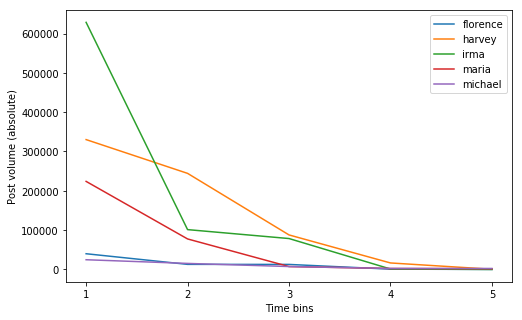

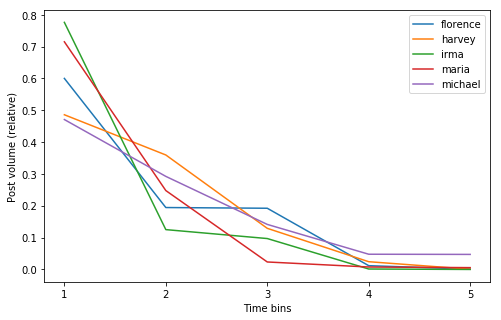

In [84]:
## absolute
plt.figure(figsize=(8, 5))
for data_name_i, data_i in combined_tag_data_time.groupby('data_name_fixed'):
#     print('data=%s'%(data_name_i))
    time_bin_counts_i = data_i.loc[:, 'date_stamp_bin'].value_counts()
    time_bins_i = sorted(time_bin_counts_i.index)
#     time_bin_mins_i = data_i.loc[:, 'date_stamp_bin_min'].unique()
#     time_bin_mins_str_i = [datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y') for x in time_bin_mins_i]
    plt.plot(time_bins_i, time_bin_counts_i, label=data_name_i)
#     plt.xticks(time_bins_i, time_bin_mins_str_i)
    plt.xticks(time_bins_i, [str(x) for x in time_bins_i])
    plt.xlabel('Time bins')
    plt.ylabel('Post volume (absolute)')
    plt.legend(loc='upper right')
plt.show()
## PDF
plt.figure(figsize=(8, 5))
for data_name_i, data_i in combined_tag_data_time.groupby('data_name_fixed'):
#     print('data=%s'%(data_name_i))
    time_bin_counts_i = data_i.loc[:, 'date_stamp_bin'].value_counts()
    time_bin_counts_i = time_bin_counts_i / time_bin_counts_i.sum()
    time_bins_i = sorted(time_bin_counts_i.index)
#     time_bin_mins_i = data_i.loc[:, 'date_stamp_bin_min'].unique()
#     time_bin_mins_str_i = [datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y') for x in time_bin_mins_i]
    plt.plot(time_bins_i, time_bin_counts_i, label=data_name_i)
#     plt.xticks(time_bins_i, time_bin_mins_str_i)
    plt.xticks(time_bins_i, [str(x) for x in time_bins_i])
    plt.xlabel('Time bins')
    plt.ylabel('Post volume (relative)')
    plt.legend(loc='upper right')
plt.show()

All the time series have similar relative trajectories: most attention focused on first few days of crisis.

Let's look at average descriptor probability over time.

$$P(descriptor | location) = \frac{P(location | descriptor) P(descriptor)}{P(location)}$$

$$P(descriptor) = P(location, descriptor) / P(location)$$

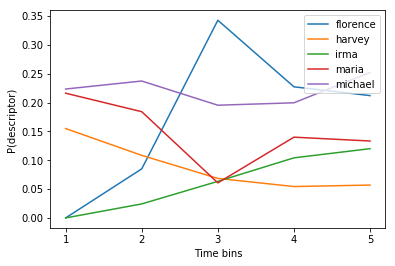

In [85]:
for data_name_i, data_i in combined_tag_data_NE_flat_time.groupby('data_name_fixed'):
#     print('data=%s'%(data_name_i))
    descriptor_prob_i = data_i.groupby('date_stamp_bin').apply(lambda x: x[x.loc[:, 'valid_loc']==1].loc[:, 'has_descriptor'].sum() / x[x.loc[:, 'valid_loc']==1].shape[0])
    time_bins_i = sorted(descriptor_prob_i.index)
#     time_bin_mins_i = data_i.loc[:, 'date_stamp_bin_min'].unique()
#     time_bin_mins_str_i = [datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y') for x in time_bin_mins_i]
    plt.plot(time_bins_i, descriptor_prob_i, label=data_name_i)
#     plt.xticks(time_bins_i, time_bin_mins_str_i)
    plt.xticks(time_bins_i, [str(x) for x in time_bins_i])
    plt.xlabel('Time bins')
    plt.ylabel('P(descriptor)')
    plt.legend(loc='upper right')

OK! No common trend, so we should try to control for variation at the NE level.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


data=florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


wilmington            1037
florence               737
carolina               487
new_bern               338
myrtle_beach           229
raleigh                213
charlotte              192
fayetteville           164
lumberton              157
charleston             120
conway                 116
wrightsville_beach     114
jacksonville           100
durham                  84
morehead_city           84
richmond                83
horry_county            74
red_cross               71
georgetown              60
brunswick               56
Name: NE_fixed, dtype: int64
testing k=[0:5)


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


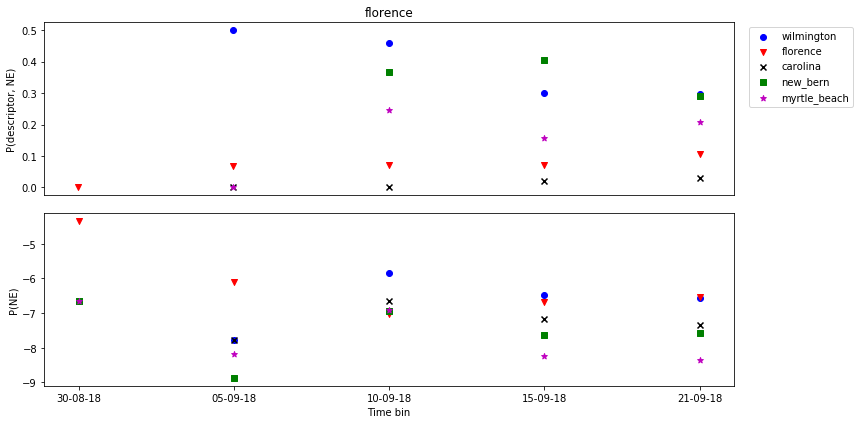

testing k=[5:10)


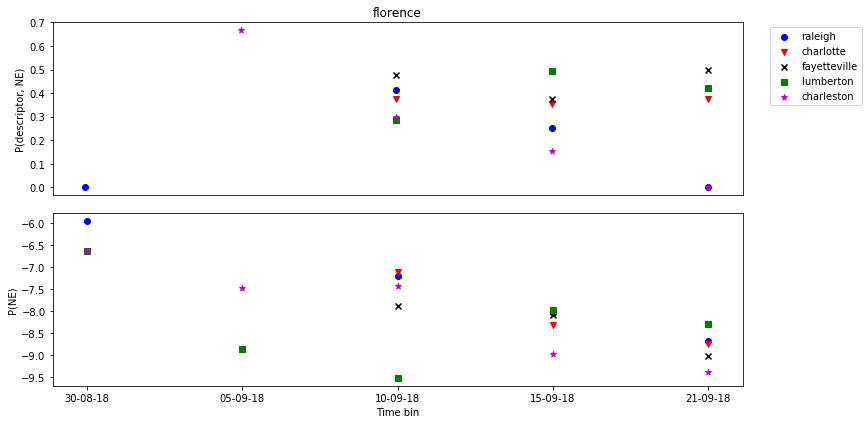

testing k=[10:15)


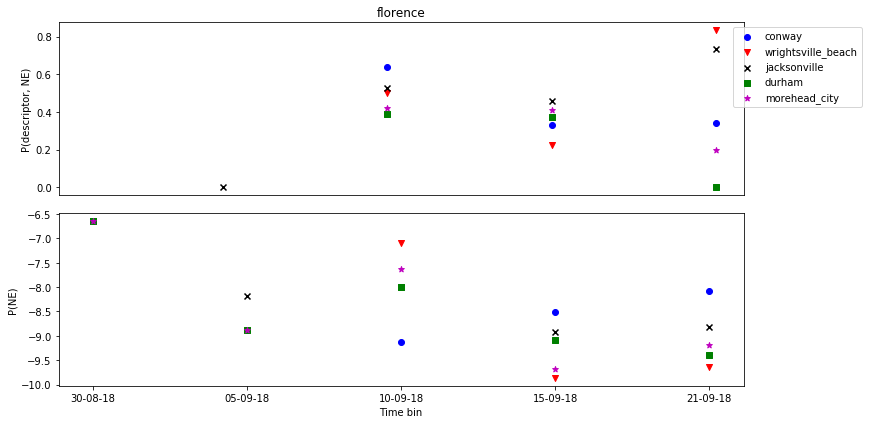

testing k=[15:20)


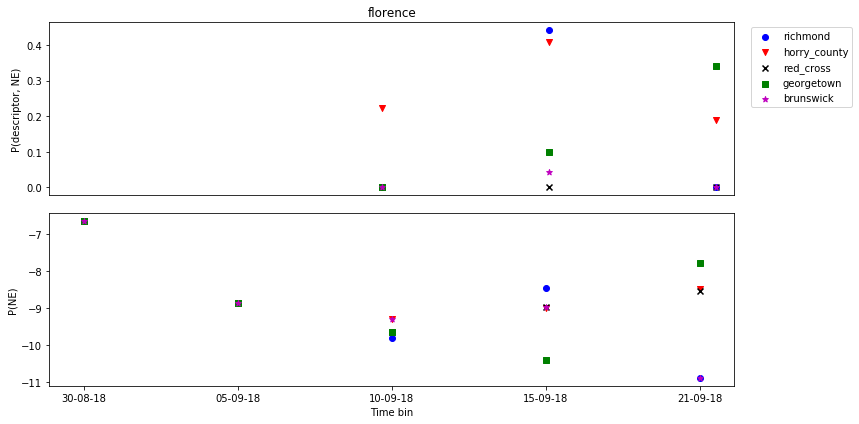

data=harvey
houston           34409
corpus_christi     3109
rockport           2510
austin             1548
dallas             1137
san_antonio        1046
galveston           838
port_aransas        806
new_orleans         618
port_arthur         551
harris_county       518
beaumont            377
dickinson           343
harvey              297
victoria            288
aransas_pass        252
port_lavaca         240
sandy               220
pearland            206
lake_charles        204
Name: NE_fixed, dtype: int64
testing k=[0:5)


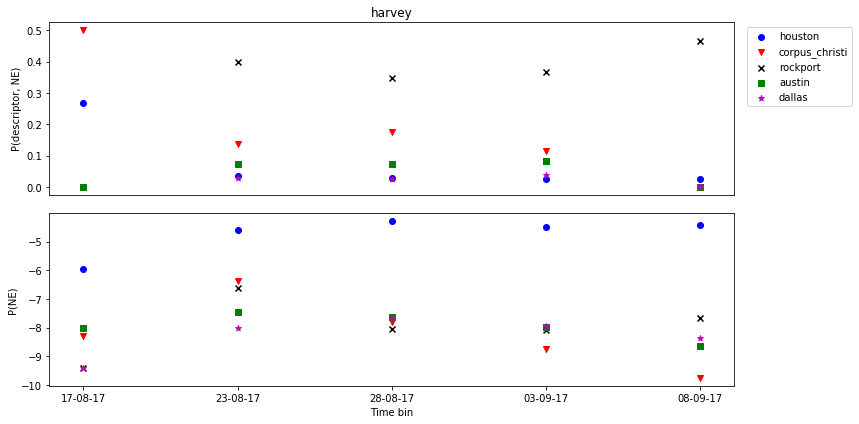

testing k=[5:10)


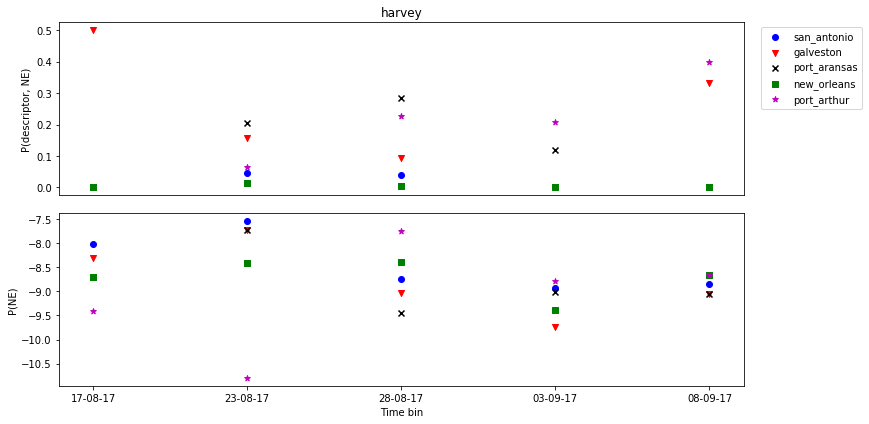

testing k=[10:15)


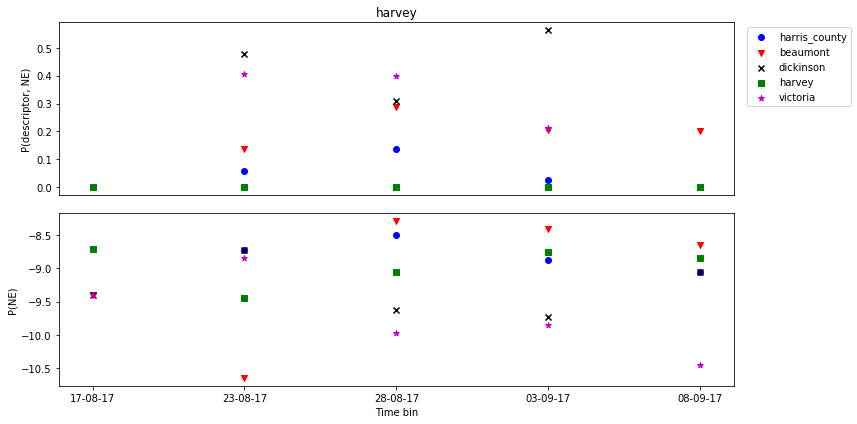

testing k=[15:20)


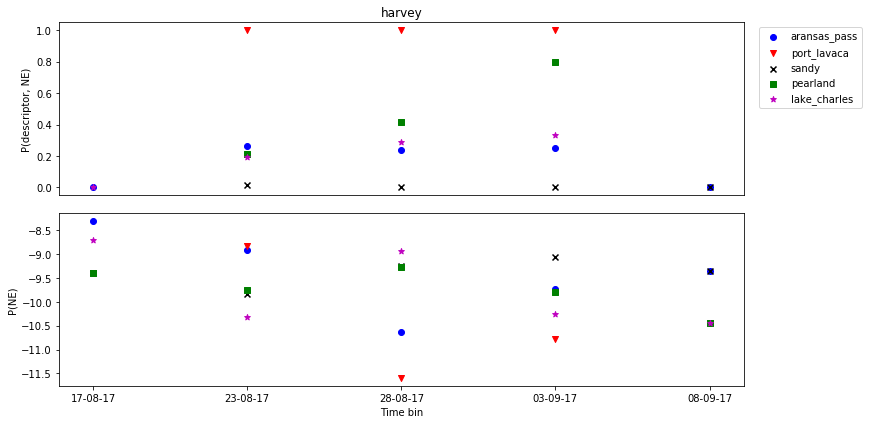

data=irma
miami                11477
tampa                 3807
naples                3356
orlando               2698
marco_island          1308
atlanta               1259
jacksonville          1097
miami_beach           1047
houston                859
charleston             685
fort_lauderdale        658
fort_myers             623
anguilla               531
palm_beach             477
broward_county         472
sarasota               459
tallahassee            426
hurricane              397
palm_beach_county      375
gainesville            375
Name: NE_fixed, dtype: int64
testing k=[0:5)


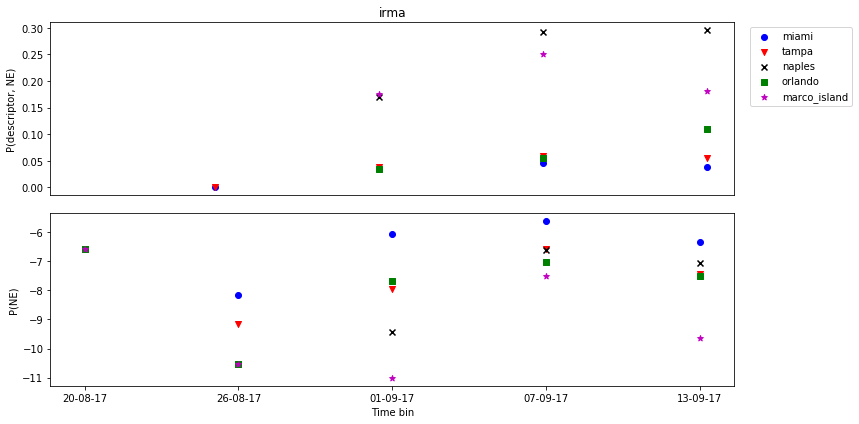

testing k=[5:10)


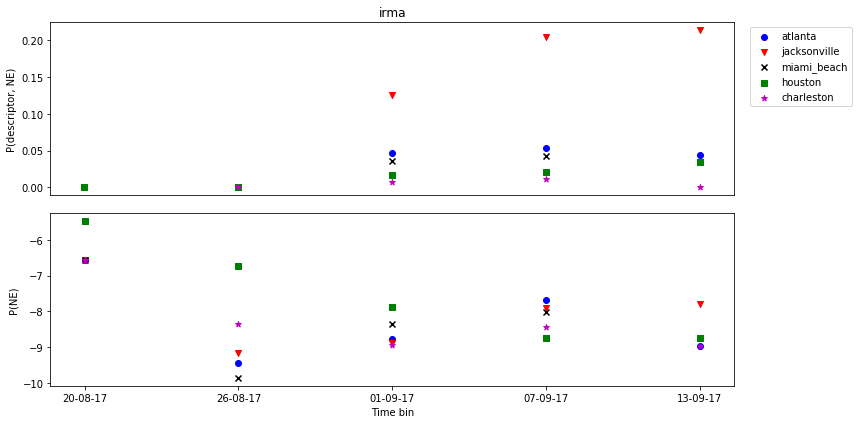

testing k=[10:15)


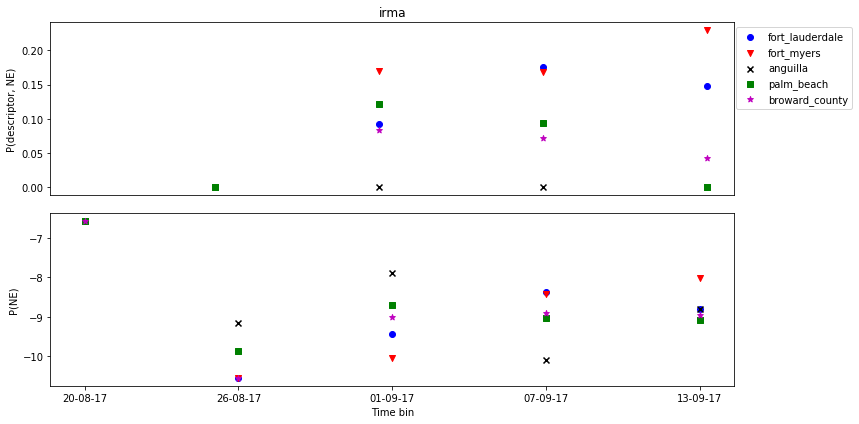

testing k=[15:20)


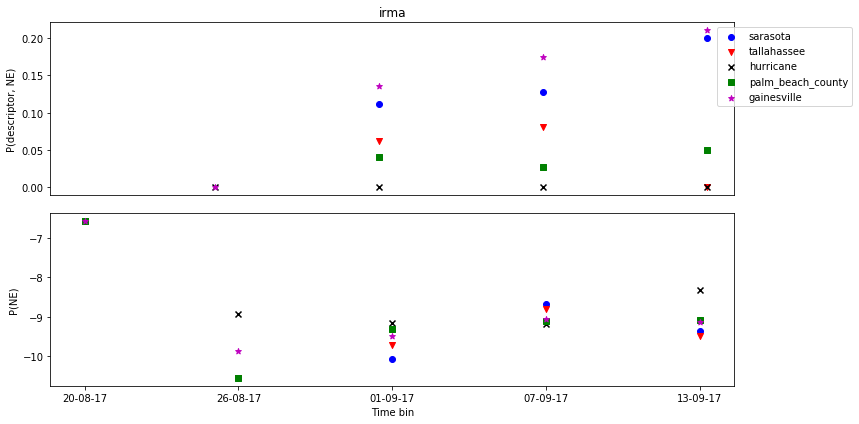

data=maria
san_juan       3510
vieques         184
ponce           119
carolina        100
caguas           95
utuado           91
guaynabo         89
yabucoa          88
las_vegas        84
aguadilla        77
arecibo          74
guayama          73
union            60
humacao          44
el_centro        42
los_angeles      40
cabo_rojo        40
bayamón          39
vegas            38
mayagüez         34
Name: NE_fixed, dtype: int64
testing k=[0:5)


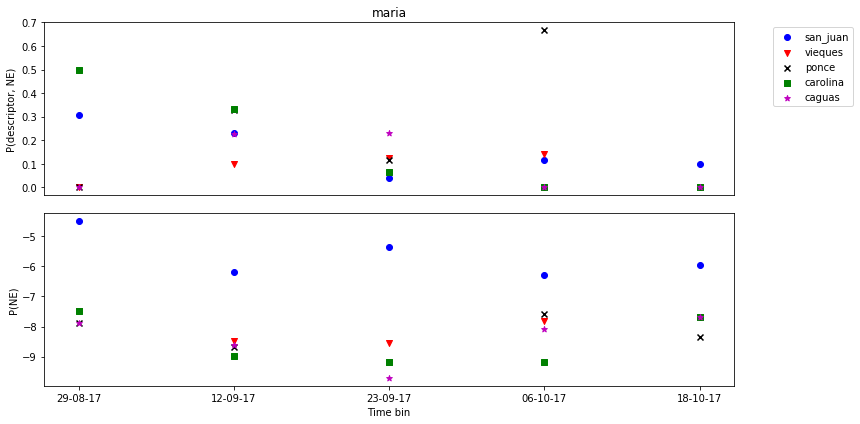

testing k=[5:10)


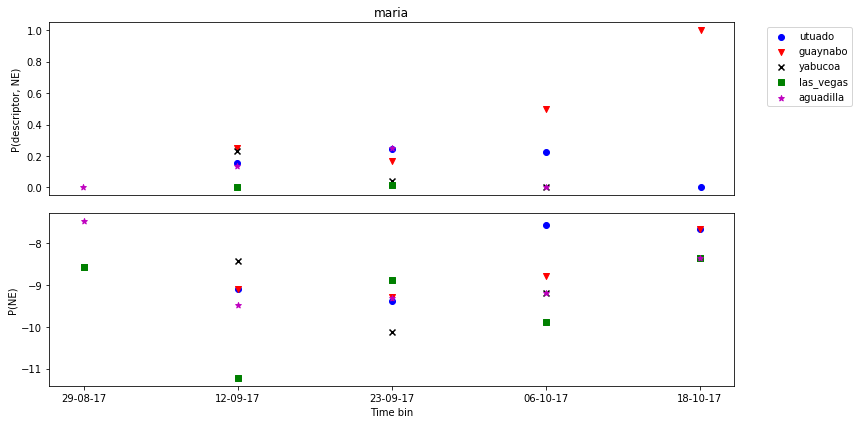

testing k=[10:15)


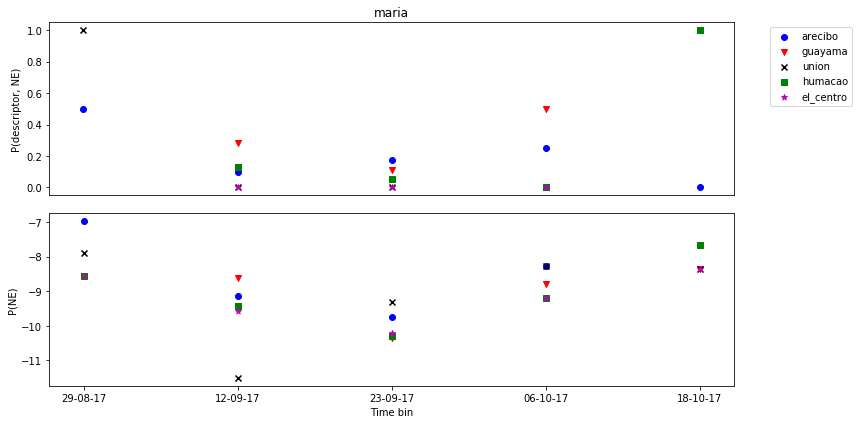

testing k=[15:20)


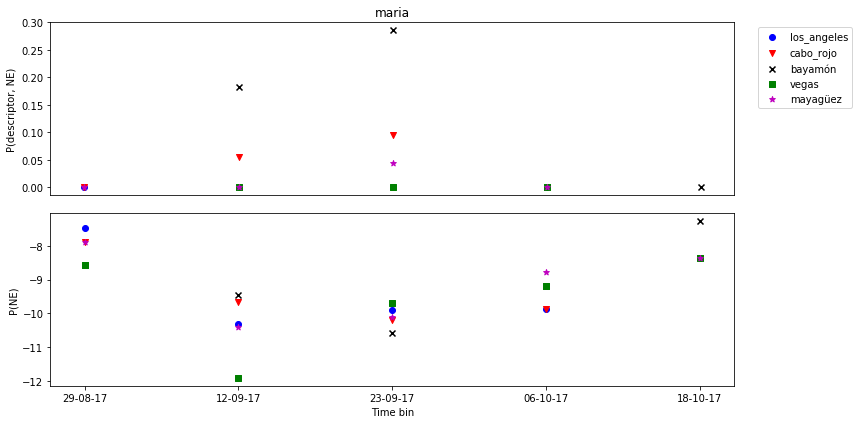

data=michael
panama_city          1201
mexico_beach         1020
tallahassee           410
panhandle             376
panama_city_beach     308
bay_county            250
lynn_haven            112
marianna               74
gulf_county            70
pensacola              67
bay                    61
atlanta                56
hurricane              55
destin                 52
jackson_county         50
raleigh                41
dothan                 38
gulf                   37
danville               31
calhoun_county         31
Name: NE_fixed, dtype: int64
testing k=[0:5)


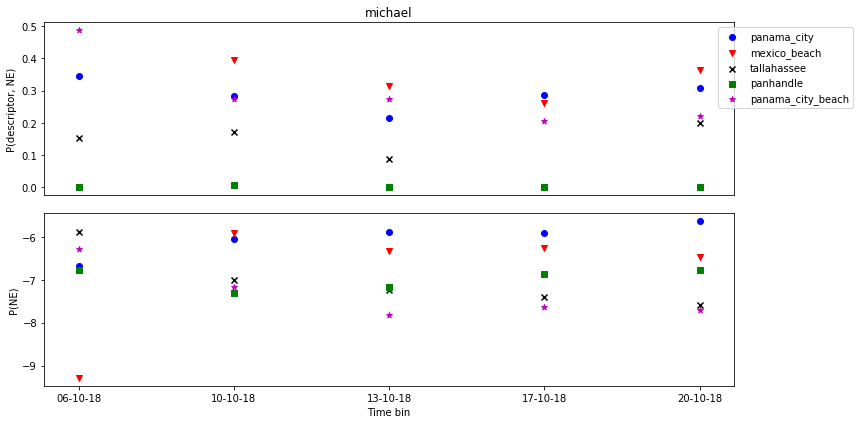

testing k=[5:10)


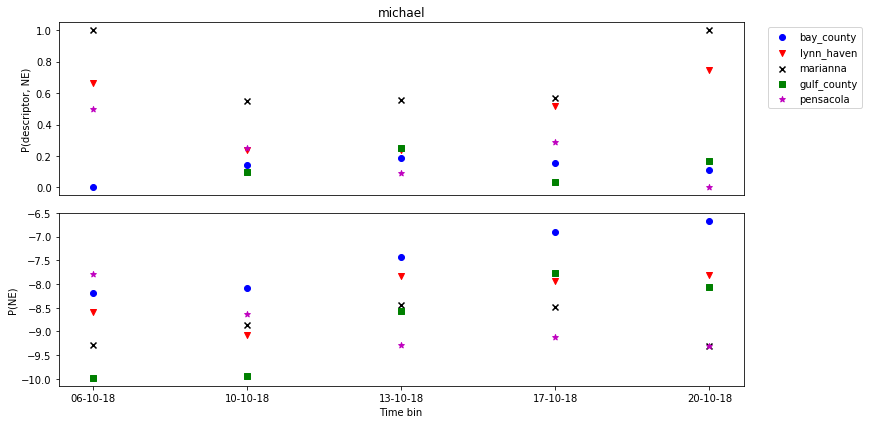

testing k=[10:15)


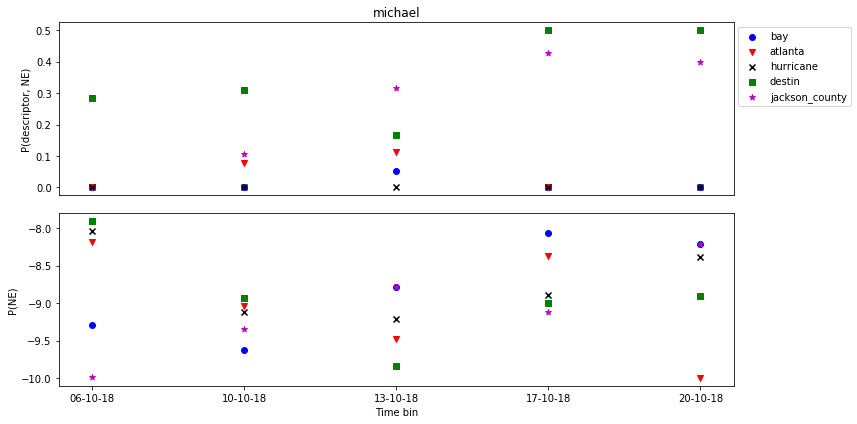

testing k=[15:20)


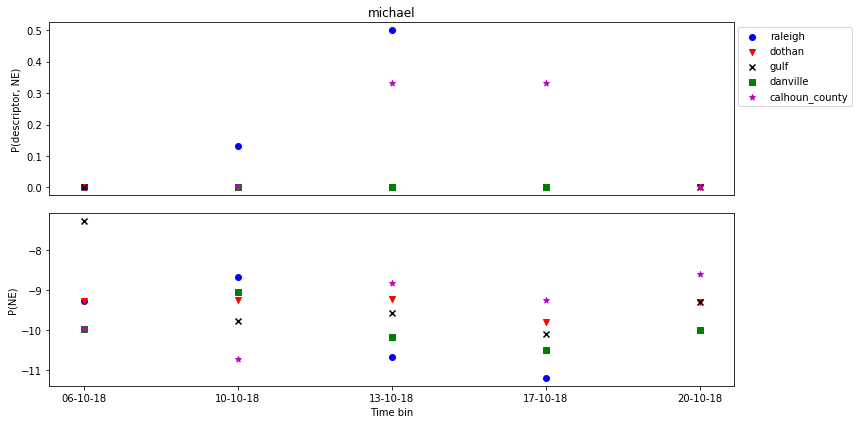

In [278]:
from itertools import cycle
from nltk.tokenize.casual import TweetTokenizer
from datetime import datetime
## step 1: probability of descriptor
## step 2: NE frequency => build DTM for each time period, normalize by total token count, etc.
# test location: San Juan
top_k = 5
top_K = 20
top_k_list = (np.linspace(top_k, top_K, top_K/top_k)-5).astype(int)
TKNZR = TweetTokenizer()
# do visualization for multiple chunks because otherwise it gets cluttered ;_;
for data_name_i, data_i in combined_tag_data_NE_flat_time.groupby('data_name_fixed'):
    print('data=%s'%(data_name_i))
    data_i.loc[:, 'NE_fixed'] = data_i.loc[:, 'NE'].apply(lambda x: x[0].lower())
    NE_counts_i = data_i[data_i.loc[:, 'valid_loc']].loc[:, 'NE_fixed'].value_counts()
    print(NE_counts_i.head(top_K))
    for top_k_low in top_k_list:
        top_k_high = top_k_low + top_k
        print('testing k=[%d:%d)'%(top_k_low, top_k_high))
        NE_k_i = NE_counts_i.index[top_k_low:top_k_high]
        
        ## plot descriptor prob
        fig, axs = plt.subplots(2, 1, figsize=(12,6))
        ax1, ax2 = axs
        linestyles = cycle(['-', '--', '-.'])
        colors = cycle(['b', 'r', 'k', 'g', 'm'])
        markers = cycle(['o', 'v', 'x', 's', '*', 'd'])
        X = sorted(data_i.loc[:, 'date_stamp_bin'].unique())
        X_labels = [datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y') for x in sorted(data_i.loc[:, 'date_stamp_bin_min'].unique())]
        ylim = [np.inf, -np.inf]
        for j, NE_j in enumerate(NE_k_i):
            data_i_j = data_i[data_i.loc[:, 'NE_fixed']==NE_j]
            NE_j_desc = data_i_j.groupby('date_stamp_bin').apply(lambda x: x.loc[:, 'has_descriptor'].sum() / x.shape[0])
            # fill in the blanks => NO this is lying
    #         NE_j_desc = NE_j_desc.loc[X].fillna(0.)
            ylim = [min(min(NE_j_desc), ylim[0]), max(max(NE_j_desc), ylim[1])]
            ax1.scatter(NE_j_desc.index, NE_j_desc, label=NE_j, marker=next(markers), c=next(colors))
        ax1.set_xticks(X)
        # shared axis = one set of labels
    #     ax1.set_xticklabels(X)
        ax1.tick_params(axis='x', bottom=False, labelbottom=False)
    #     ax1.set_xlabel('Time bin')
        ax1.set_ylabel('P(descriptor, NE)')
        ax1.legend(loc='upper right', bbox_to_anchor=[1.18, 1.])
        ax1.set_title(data_name_i)
        # add ylim buffer
        ylim_range = ylim[1] - ylim[0]
        ylim_buffer = ylim_range*.05
        ylim = [ylim[0] - ylim_buffer, ylim[1] + ylim_buffer]
        ax1.set_ylim(ylim)
    #     plt.show()
    
        ## plot frequency
        linestyles = cycle(['-', '--', '-.'])
        colors = cycle(['b', 'r', 'k', 'g', 'm'])
        markers = cycle(['o', 'v', 'x', 's', '*', 'd'])
        ## TODO: this isn't really token frequency...we need the full tweet collection for freq estimation
        data_i_token_f = data_i.groupby('date_stamp_bin').apply(lambda x: x.loc[:, 'txt'].apply(lambda y: len(TKNZR.tokenize(y))).sum())
        ylim = [np.inf, -np.inf]
        for j, NE_j in enumerate(NE_k_i):
            data_i_j = data_i[data_i.loc[:, 'NE_fixed']==NE_j]
            NE_j_f = data_i_j.groupby('date_stamp_bin').apply(lambda x: x.shape[0])
            NE_j_f = NE_j_f.loc[X].fillna(0.)
#             NE_j_f = NE_j_f / data_i_token_f
            # log-frequency
            NE_j_f = np.log((NE_j_f+1.)/data_i_token_f)
            ylim = [min(min(NE_j_f), ylim[0]), max(max(NE_j_f), ylim[1])]
            ax2.scatter(X, NE_j_f, label=NE_j, marker=next(markers), c=next(colors))
        ax2.set_xticks(X)
        ax2.set_xticklabels(X_labels)
        ax2.set_xlabel('Time bin')
        ax2.set_ylabel('P(NE)')
    #     ax2.legend(loc='upper right', bbox_to_anchor=[1.65, 1.])
    #     ax2.set_title(data_name_i)
        # add ylim buffer
        ylim_range = ylim[1] - ylim[0]
        ylim_buffer = ylim_range*.05
        ylim = [ylim[0] - ylim_buffer, ylim[1] + ylim_buffer]
        ax2.set_ylim(ylim)
        plt.tight_layout()
        plt.show()
    #     break
    #     test_NE = 'san_juan' # replace with top-k locations for each crisis
    #     test_data_i = data_i[data_i.loc[:, 'NE_fixed']==test_NE]
    #     test_data_i_desc = test_data_i.groupby('date_stamp_bin').apply(lambda x: x.loc[:, 'has_descriptor'].sum() / x.shape[0])
    #     # print(test_data_i_desc)
    #     plt.plot(test_data_i_desc.index, test_data_i_desc, label=test_NE)
    #     plt.xticks(test_data_i_desc.index, test_data_i_desc.index)
    #     plt.xlabel('Time bin')
    #     plt.ylabel('P(descriptor)')
    #     plt.show()

We see a lot of variance in the trajectories here. The expected trajectory is for NEs to gain collective attention, which implies a decrease in the descriptor probability. However, this really only happens for a few entities like `San Juan`, while the others either show steady growth, late growth or random fluctuation.

### Correlation between entity status, descriptor probability
Basic hypothesis test: lesser-known NEs are more likely to have descriptors than more-known NEs. We use the maximum population over the location candidates as a proxy for how well-known a location is.

TODO: we might have to backoff to the nearest-highest-population, or restrict to NEs with a non-zero population, or bin by population category...BLAH.

In [87]:
combined_tag_data_NE_flat_valid = combined_tag_data_NE_flat[combined_tag_data_NE_flat.loc[:, 'valid_loc']==1]
print('%d valid locations'%(combined_tag_data_NE_flat_valid.shape[0]))

167228 valid locations


In [88]:
geonames_pop_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False, usecols=['geonames_ID', 'population', 'alternate_name_count'])
geonames_pop_data.fillna(0, inplace=True)
# display(geonames_pop_data.head())
geonames_data = pd.concat([geonames_name_data, geonames_pop_data], axis=1)
# print(geonames_data.shape[0])
# display(geonames_data.head())

In [89]:
max_pop_dict = {k : geonames_pop_data.loc[v.index, 'population'].max() for k,v in geo_dict.items()}
max_name_dict = {k : geonames_pop_data.loc[v.index, 'alternate_name_count'].max() for k,v in geo_dict.items()}
## replace nans with 0
max_pop_dict = dict([(k,v) if (not np.isnan(v)) else (k,0) for k,v in max_pop_dict.items()])
max_name_dict = dict([(k,v) if (not np.isnan(v)) else (k,0) for k,v in max_name_dict.items()])

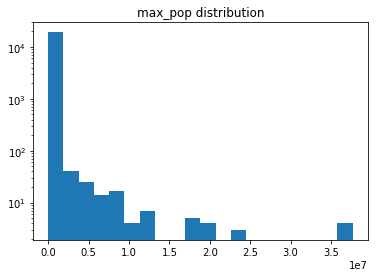

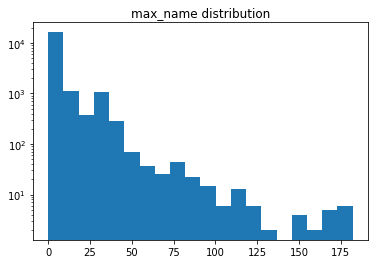

In [90]:
# plot the pop/name distributions
plt.hist(max_pop_dict.values(), bins=20)
plt.yscale('log')
plt.title('max_pop distribution')
plt.show()
plt.hist(max_name_dict.values(), bins=20)
plt.yscale('log')
plt.title('max_name distribution')
plt.show()

OK! As expected, most locations have a `max_pop` and `max_name` around 0.

Now let's do some hypothesis testing: 

- H1: correlation between P(descriptor) and `importance` != 0
- H1: low-population locations have lower P(descriptor) than high-population locations (split point, filtering TBD)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1909 valid probs


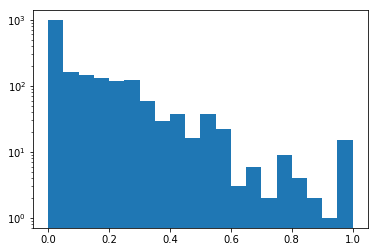

In [91]:
from unidecode import unidecode
# compute P(descriptor) for all NEs with > min 
min_NE_count = 3
combined_tag_data_NE_flat_valid.loc[:, 'NE_fixed'] = combined_tag_data_NE_flat_valid.loc[:, 'NE'].apply(lambda x: unidecode(x[0].lower().replace('_', ' ')))
NE_descriptor_probs = []
for NE_i, NE_data_i in combined_tag_data_NE_flat_valid.groupby('NE_fixed'):
    if(NE_data_i.shape[0] > min_NE_count):
        NE_descriptor_prob_i = NE_data_i.loc[:, 'has_descriptor'].sum() / NE_data_i.shape[0]
        NE_descriptor_probs.append((NE_i, NE_descriptor_prob_i))
NE_descriptor_probs = pd.Series(dict(NE_descriptor_probs))
print('%d valid probs'%(len(NE_descriptor_probs)))
plt.hist(NE_descriptor_probs, bins=20)
plt.yscale('log')
plt.show()

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


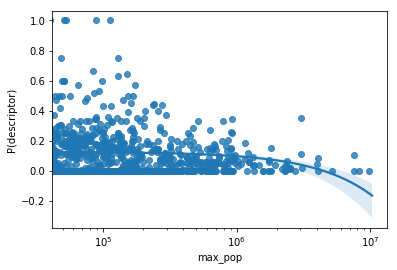

correlation between max_pop and P(descriptor) = -0.0825 (p=3.089E-04)


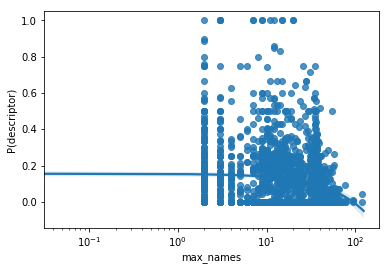

correlation between max_names and P(descriptor) = -0.1485 (p=7.091E-11)


In [92]:
import seaborn as sns
from scipy.stats import pearsonr
importance_stat_names = ['max_pop', 'max_names']
importance_stat_dicts = [max_pop_dict, max_name_dict]
NE_descriptor_probs_log = np.log(NE_descriptor_probs+1e-4)
for stat_name, stat_dict in zip(importance_stat_names, importance_stat_dicts):
    stat_dict_vals = np.array([stat_dict[k] for k in NE_descriptor_probs.index])
    stat_dict_vals_smooth = stat_dict_vals + 1.
    # untransformed
    sns.regplot(stat_dict_vals_smooth, NE_descriptor_probs)
    plt.xlabel(stat_name)
    plt.ylabel('P(descriptor)')
    plt.xscale('log')
    plt.show()
    corr, p_val = pearsonr(stat_dict_vals_smooth, NE_descriptor_probs)
    print('correlation between %s and P(descriptor) = %.4f (p=%.3E)'%(stat_name, corr, p_val))
    # log-transformed
    # remove zero vals
#     stat_dict_vals_, NE_descriptor_probs_ = zip([x for x in stat_dict_vals if x > 0.], NE_descriptor_probs)
#     stat_dict_vals_log = np.log(stat_dict_vals_)
#     sns.regplot(stat_dict_vals_log, NE_descriptor_probs_)
#     plt.xlabel(stat_name)
#     plt.ylabel('P(descriptor)')
#     plt.show()
#     corr, p_val = pearsonr(stat_dict_vals_log, NE_descriptor_probs)
#     print('correlation between log(%s) and P(descriptor) = %.4f (p=%.3E)'%(stat_name, corr, p_val))

Weak negative correlation with both importance stats suggests that higher "importance" means less need for descriptor.

Let's confirm this with some hypothesis testing and boxplots.

testing all probs


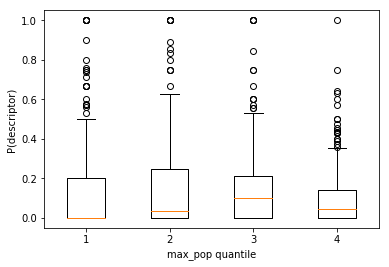

significant difference -0.022 between quantiles 1 and 2: test=102535.500 (p=2.142E-03)
significant difference -0.016 between quantiles 1 and 3: test=95740.500 (p=3.565E-06)
significant difference 0.029 between quantiles 1 and 4: test=103720.000 (p=5.250E-03)
significant difference 0.045 between quantiles 3 and 4: test=98034.500 (p=5.831E-05)
testing nonzero probs


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


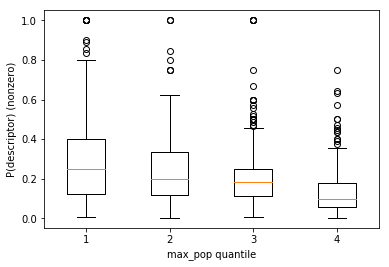

significant difference 0.075 between quantiles 1 and 3: test=27439.000 (p=6.059E-05)
significant difference 0.155 between quantiles 1 and 4: test=18001.500 (p=5.756E-21)
significant difference 0.107 between quantiles 2 and 4: test=19730.500 (p=4.482E-17)
significant difference 0.080 between quantiles 3 and 4: test=21203.500 (p=4.257E-14)
testing all probs


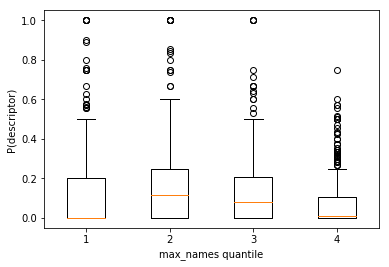

significant difference -0.039 between quantiles 1 and 2: test=90862.000 (p=1.333E-06)
significant difference -0.010 between quantiles 1 and 3: test=88223.000 (p=1.297E-03)
significant difference 0.086 between quantiles 2 and 4: test=97255.500 (p=1.987E-12)
significant difference 0.058 between quantiles 3 and 4: test=95319.500 (p=1.905E-07)
testing nonzero probs


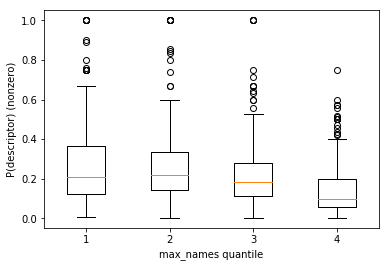

significant difference 0.121 between quantiles 1 and 4: test=21293.000 (p=2.305E-15)
significant difference 0.041 between quantiles 2 and 3: test=27985.000 (p=2.163E-03)
significant difference 0.118 between quantiles 2 and 4: test=20956.000 (p=2.615E-19)
significant difference 0.077 between quantiles 3 and 4: test=24255.000 (p=1.438E-11)


In [93]:
from scipy.stats import mannwhitneyu
N_percentiles = 4
percentiles = np.linspace(0., 100., 5)[:-1]
percentile_pairs = list(zip(percentiles, percentiles + 1/N_percentiles))
for stat_name, stat_dict in zip(importance_stat_names, importance_stat_dicts):
    stat_ser = pd.DataFrame(pd.Series(stat_dict)).loc[NE_descriptor_probs.index]
    stat_data_combined = pd.concat([NE_descriptor_probs, stat_ser], axis=1)
    stat_data_combined.columns = ['NE_descriptor_prob', stat_name]
    ## test all probabilities
    print('testing all probs')
    # group by percentile
    stat_percentiles = [np.percentile(stat_data_combined.loc[:, stat_name], pct) for pct in percentiles]
    stat_data_combined.loc[:, 'stat_bin'] = np.digitize(stat_data_combined.loc[:, stat_name], stat_percentiles, right=False)
#     print(stat_data_combined.loc[:, 'stat_bin'].value_counts())
    prob_percentiles = [x.loc[:, 'NE_descriptor_prob'].values for i,x in stat_data_combined.groupby('stat_bin')]
    plt.boxplot(prob_percentiles)
    plt.xlabel('%s quantile'%(stat_name))
    plt.ylabel('P(descriptor)')
    plt.show()
    ## test differences => non-normal distributions
    p_val_corrected = 0.05 / ((N_percentiles * (N_percentiles-1))/2)
    for i in range(N_percentiles):
        for j in range(i, N_percentiles):
            test_stat, p_val = mannwhitneyu(prob_percentiles[i], prob_percentiles[j])
            if(p_val < p_val_corrected):
                diff_i_j = np.mean(prob_percentiles[i]) - np.mean(prob_percentiles[j])
                print('significant difference %.3f between quantiles %d and %d: test=%.3f (p=%.3E)'%(diff_i_j, i+1, j+1, test_stat, p_val))
    ## same thing but with stat > 0
    print('testing nonzero probs')
    stat_data_combined_nonzero = stat_data_combined[stat_data_combined.loc[:, 'NE_descriptor_prob'] > 0]
#     print('%d nonzero data'%(stat_data_combined_nonzero.shape[0]))
    stat_percentiles = [np.percentile(stat_data_combined_nonzero.loc[:, stat_name], pct) for pct in percentiles]
#     print(stat_percentiles)
    stat_data_combined_nonzero.loc[:, 'stat_bin'] = np.digitize(stat_data_combined_nonzero.loc[:, stat_name], stat_percentiles, right=False)
#     print(stat_data_combined.loc[:, 'stat_bin'].value_counts())
    prob_percentiles = [x.loc[:, 'NE_descriptor_prob'].values for i,x in stat_data_combined_nonzero.groupby('stat_bin')]
    plt.boxplot(prob_percentiles)
    plt.xlabel('%s quantile'%(stat_name))
    plt.ylabel('P(descriptor) (nonzero)')
    plt.show()
    ## test differences => non-normal distributions
    p_val_corrected = 0.05 / ((N_percentiles * (N_percentiles-1))/2)
    for i in range(N_percentiles):
        for j in range(i, N_percentiles):
            test_stat, p_val = mannwhitneyu(prob_percentiles[i], prob_percentiles[j])
            if(p_val < p_val_corrected):
                diff_i_j = np.mean(prob_percentiles[i]) - np.mean(prob_percentiles[j])
                print('significant difference %.3f between quantiles %d and %d: test=%.3f (p=%.3E)'%(diff_i_j, i+1, j+1, test_stat, p_val))
# print(quantiles)

Weak evidence in support of the "importance implies older information status", if we focus on cases where $P(\text{descriptor}) > 0$.

### Compare P(descriptor) according to importance over time
Before regression, let's figure out if the less important locations ("Boca Raton" => "Boca Raton, FL") undergo a qualitatively different shift from the more important locations ("San Juan, PR" -> "San Juan") as a result of differing audience constraints.

H1: more important locations have less variance in P(descriptor) than less important locations.

In [106]:
# organize temporal data
descriptor_pred_data = pd.merge(combined_tag_data_NE_flat_valid, combined_tag_data_NE_flat_time.loc[:, ['id', 'date_stamp_bin', 'date_stamp_bin_min']], on='id', how='left')
## add max_pop, max_name
descriptor_pred_data.loc[:, 'max_pop'] = descriptor_pred_data.loc[:, 'NE_fixed'].apply(lambda x: max_pop_dict[x])
descriptor_pred_data.loc[:, 'max_names'] = descriptor_pred_data.loc[:, 'NE_fixed'].apply(lambda x: max_name_dict[x])
# log transforms
descriptor_pred_data.loc[:, 'max_pop_log'] = descriptor_pred_data.loc[:, 'max_pop'].apply(lambda x: np.log(x+1))
descriptor_pred_data.loc[:, 'max_names_log'] = descriptor_pred_data.loc[:, 'max_names'].apply(lambda x: np.log(x+1))

In [115]:
def bucket(x, low, high):
    if(x <= low):
        return 'low'
    elif(x > high):
        return 'high'
    return 'mid'
def compute_aggregate_probs(x):
    x_prob = x.loc[:, 'has_descriptor'].mean()
    x_var = 1.96*x.loc[:, 'has_descriptor'].std()/(x.shape[0]**.5)
    x_data = pd.Series([x_prob, x_var, x.loc[:, 'importance_bin'].iloc[0], x.loc[:, 'date_stamp_bin'].iloc[0], x.loc[:, 'date_stamp_bin_min'].iloc[0]], 
                       index=['descriptor_prob', 'descriptor_prob_var', 'importance_bin', 'date_stamp_bin', 'date_stamp_bin_min'])
    return x_data
def convert_timestamp_to_date(x, date_fmt='%d-%m-%y'):
    x_date = datetime.strftime(datetime.fromtimestamp(x), date_fmt)
    return x_date

testing max_pop_log bin 0
mexico beach    1245
port aransas    1004
anguilla         728
panhandle        578
alert            294
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
rockport             2954
marco island         1602
hurricane             839
gulf                  630
panama city beach     395
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
naples         4159
panama city    1538
port arthur     660
new bern        442
center          441
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
houston           41141
miami             13610
tampa              4829
san juan           3786
corpus christi     3611
Name: NE_fixed, dtype: int64


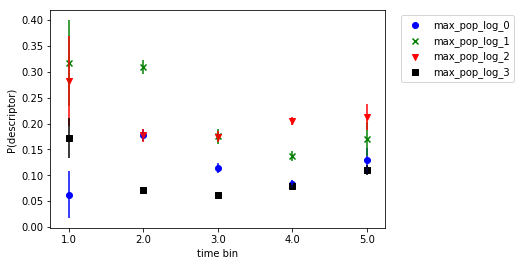

testing max_names_log bin 0
rockport        2954
marco island    1602
mexico beach    1245
port aransas    1004
carolina         949
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
tampa             4829
naples            4159
corpus christi    3611
orlando           3434
panama city       1538
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
miami          13610
austin          1877
dallas          1479
san antonio     1346
wilmington      1329
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
houston         41141
san juan         3786
atlanta          1835
jacksonville     1512
new orleans       834
Name: NE_fixed, dtype: int64


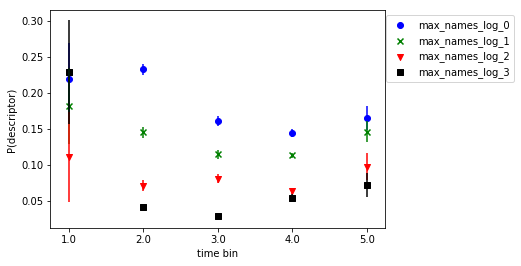

In [110]:
import seaborn as sns
from itertools import cycle
# compute P(descriptor) for (1) low-importance (2) high-importance NEs 
low_pct_upper = 50
high_pct_lower = 50
N_importance_bins = 4
top_k_NE = 5
for importance_stat_i in importance_stat_names:
    importance_stat_i = '%s_log'%(importance_stat_i)
    # separate data by percentile
    low_pct_upper_i = np.percentile(descriptor_pred_data.drop_duplicates('NE_fixed').loc[:, importance_stat_i], low_pct_upper)
    high_pct_lower_i = np.percentile(descriptor_pred_data.drop_duplicates('NE_fixed').loc[:, importance_stat_i], high_pct_lower)
    descriptor_pred_data_i = descriptor_pred_data.copy()
    # bin data
    # fixed-width
#     importance_stat_bins = np.linspace(descriptor_pred_data_i.loc[:, importance_stat_i].min(), descriptor_pred_data_i.loc[:, importance_stat_i].max(), N_importance_bins)[1:]
    # percentiles
    importance_stat_unique = descriptor_pred_data_i.loc[:, importance_stat_i].unique()
    importance_stat_bins = [np.percentile(importance_stat_unique, pct) for pct in np.linspace(0, 100, N_importance_bins+1)[1:]]
    descriptor_pred_data_i.loc[:, 'importance_bin'] = np.digitize(descriptor_pred_data_i.loc[:, importance_stat_i], bins=importance_stat_bins, right=True).astype(int)
    ## sanity check: print top-k entities in each bin
    for bin_j, bin_data_j in descriptor_pred_data_i.groupby('importance_bin'):
        print('testing %s bin %d'%(importance_stat_i, bin_j))
        print(bin_data_j.loc[:, 'NE_fixed'].value_counts()[:top_k_NE])
    # group by NE, time bin
    descriptor_pred_data_i_flat = descriptor_pred_data_i.groupby(['date_stamp_bin', 'importance_bin']).apply(lambda x: compute_aggregate_probs(x)).reset_index(drop=True)
    colors = cycle(['b', 'g', 'r', 'k', 'm', 'p'])
    markers = cycle(['o', 'x', 'v', 's'])
    for data_name_j, data_j in descriptor_pred_data_i_flat.groupby('importance_bin'):
        color_j = next(colors)
        marker_j = next(markers)
        plt.scatter(data_j.loc[:, 'date_stamp_bin'], data_j.loc[:, 'descriptor_prob'], label='%s_%d'%(importance_stat_i, data_name_j), c=color_j, marker=marker_j)
        plt.errorbar(data_j.loc[:, 'date_stamp_bin'], data_j.loc[:, 'descriptor_prob'], yerr=data_j.loc[:, 'descriptor_prob_var'], c=color_j, linestyle='', label='')
    X = descriptor_pred_data_i_flat.loc[:, 'date_stamp_bin'].unique()
    plt.xticks(X, X)
    plt.xlabel('time bin')
    plt.ylabel('P(descriptor)')
    plt.legend(loc='upper right', bbox_to_anchor=[1.4, 1.])
    plt.show()

Let's do the same analysis but for different data sets.

processing data florence with 9995 samples
testing max_pop_log bin 0
pee dee           62
cape fear         54
bermuda           36
alert             33
pawleys island    24
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
new bern              441
myrtle beach          298
lumberton             204
wrightsville beach    132
morehead city         106
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
wilmington      1289
florence         893
carolina         556
raleigh          273
fayetteville     255
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
long island    2
Name: NE_fixed, dtype: int64


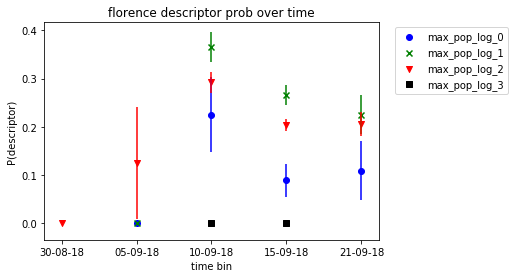

testing max_names_log bin 0
wrightsville beach    132
red cross              79
pee dee                62
cape fear              54
chapel hill            53
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
carolina         556
new bern         441
myrtle beach     298
lumberton        204
morehead city    106
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
wilmington      1289
florence         893
raleigh          273
fayetteville     255
charlotte        239
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
milwaukee    3
Name: NE_fixed, dtype: int64


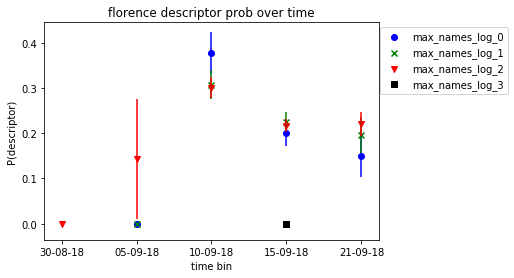

processing data harvey with 74029 samples
testing max_pop_log bin 0
senate             146
africa             117
san jose island    101
asia                97
cypress creek       92
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
rockport        2954
port aransas    1004
harvey           408
dickinson        376
aransas pass     341
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
houston           38837
corpus christi     3611
austin             1876
dallas             1394
san antonio        1300
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
los angeles    68
Name: NE_fixed, dtype: int64


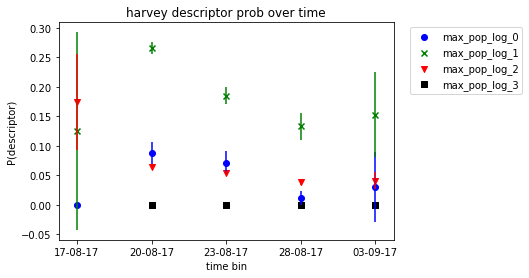

testing max_names_log bin 0
port aransas         1004
port o'connor         190
senate                146
africa                117
sienna plantation     117
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
rockport        2954
port arthur      660
beaumont         477
aransas pass     341
port lavaca      286
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
houston           38837
corpus christi     3611
austin             1876
dallas             1394
san antonio        1300
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
los angeles    68
Name: NE_fixed, dtype: int64


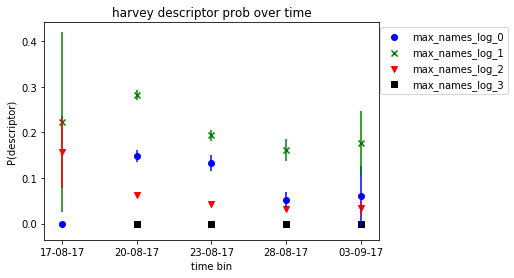

processing data irma with 70327 samples
testing max_pop_log bin 0
alert           253
bermuda          98
turkey point     80
san marco        59
south tampa      57
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
naples          4137
marco island    1602
anguilla         727
hurricane        542
gulf             528
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
miami      13175
tampa       4793
orlando     3300
houston     2224
atlanta     1568
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
manhattan    16
Name: NE_fixed, dtype: int64


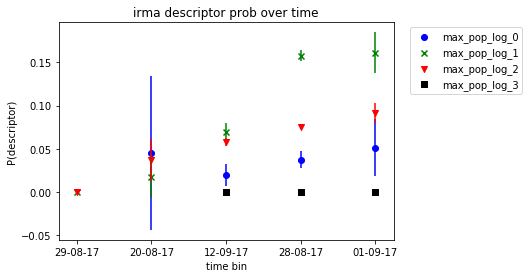

testing max_names_log bin 0
anguilla               727
alert                  253
south beach            241
beach                  185
hillsborough county    112
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
tampa           4793
naples          4137
marco island    1602
miami beach     1122
fort myers       811
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
miami           13175
orlando          3300
houston          2224
atlanta          1568
jacksonville     1323
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
lax    23
Name: NE_fixed, dtype: int64


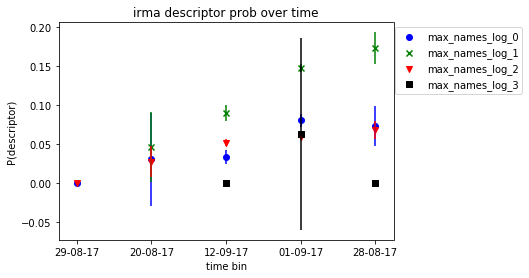

processing data maria with 7228 samples
testing max_pop_log bin 0
santurce         29
isla verde       23
old san juan     19
cayo santiago    17
altagracia       16
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
vieques         216
utuado          110
yabucoa         103
guayama          84
quebradillas     53
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
san juan    3773
ponce        140
carolina     119
caguas       112
guaynabo     108
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
los angeles    44
Name: NE_fixed, dtype: int64


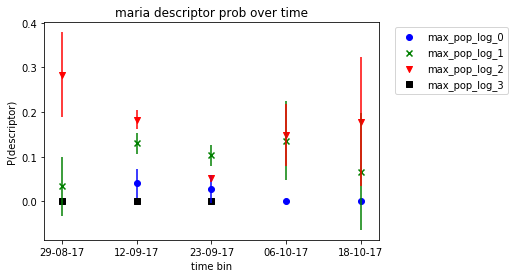

testing max_names_log bin 0
guaynabo     108
yabucoa      103
toa baja      42
levittown     33
cayey         33
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
vieques     216
ponce       140
carolina    119
caguas      112
utuado      110
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
san juan     3773
las vegas      93
union          63
vegas          42
nola           33
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
los angeles    44
Name: NE_fixed, dtype: int64


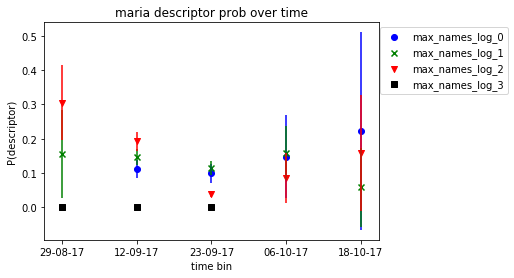

processing data michael with 8561 samples
testing max_pop_log bin 0
george island      23
pensacola beach    12
dog island         11
beacon hill        10
florida beach       9
Name: NE_fixed, dtype: int64
testing max_pop_log bin 1
panama city          1464
mexico beach         1243
panhandle             508
panama city beach     357
lynn haven            147
Name: NE_fixed, dtype: int64
testing max_pop_log bin 2
tallahassee    482
bay county     311
pensacola       83
bay             81
atlanta         69
Name: NE_fixed, dtype: int64
testing max_pop_log bin 3
manhattan    2
Name: NE_fixed, dtype: int64


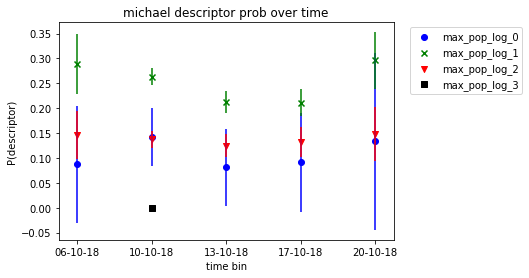

testing max_names_log bin 0
mexico beach    1243
panhandle        508
beach             25
wewahitchka       20
inland            18
Name: NE_fixed, dtype: int64
testing max_names_log bin 1
panama city          1464
panama city beach     357
lynn haven            147
marianna               95
pensacola              83
Name: NE_fixed, dtype: int64
testing max_names_log bin 2
tallahassee    482
bay county     311
gulf            97
gulf county     90
bay             81
Name: NE_fixed, dtype: int64
testing max_names_log bin 3
manhattan    2
Name: NE_fixed, dtype: int64


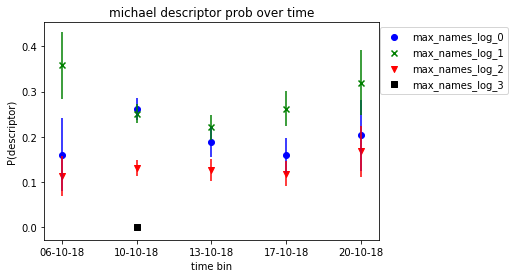

In [116]:
# same thing but across different data sets
top_k_NE = 5
N_importance_bins = 4
for data_name_k, data_k in descriptor_pred_data.groupby('data_name_fixed'):
    print('processing data %s with %d samples'%(data_name_k, data_k.shape[0]))
    for importance_stat_i in importance_stat_names:
        importance_stat_i = '%s_log'%(importance_stat_i)
        # separate data by percentile
        low_pct_upper_i = np.percentile(data_k.drop_duplicates('NE_fixed').loc[:, importance_stat_i], low_pct_upper)
        high_pct_lower_i = np.percentile(data_k.drop_duplicates('NE_fixed').loc[:, importance_stat_i], high_pct_lower)
        data_k_i = data_k.copy()
        # compute bins
        importance_stat_bins = np.linspace(data_k_i.loc[:, importance_stat_i].min(), data_k_i.loc[:, importance_stat_i].max(), N_importance_bins)[1:]
        data_k_i.loc[:, 'importance_bin'] = np.digitize(data_k_i.loc[:, importance_stat_i], bins=importance_stat_bins).astype(int)
        # show examples of NEs by bin
        for bin_j, bin_data_j in data_k_i.groupby('importance_bin'):
            print('testing %s bin %d'%(importance_stat_i, bin_j))
            print(bin_data_j.loc[:, 'NE_fixed'].value_counts()[:top_k_NE])
        # group by NE, time bin
        data_k_i_flat = data_k_i.groupby(['date_stamp_bin', 'importance_bin']).apply(lambda x: compute_aggregate_probs(x)).reset_index(drop=True)

        colors = cycle(['b', 'g', 'r', 'k', 'm', 'p'])
        markers = cycle(['o', 'x', 'v', 's'])
        for data_name_j, data_j in data_k_i_flat.groupby('importance_bin'):
            color_j = next(colors)
            marker_j = next(markers)
            plt.scatter(data_j.loc[:, 'date_stamp_bin'], data_j.loc[:, 'descriptor_prob'], label='%s_%d'%(importance_stat_i, data_name_j), c=color_j, marker=marker_j)
            plt.errorbar(data_j.loc[:, 'date_stamp_bin'], data_j.loc[:, 'descriptor_prob'], yerr=data_j.loc[:, 'descriptor_prob_var'], c=color_j, linestyle='', label='')
        X = data_k_i_flat.loc[:, 'date_stamp_bin'].unique()
        X_labels = [convert_timestamp_to_date(x) for x in data_k_i_flat.loc[:, 'date_stamp_bin_min'].unique()]
        plt.xticks(X, X_labels)
        plt.xlabel('time bin')
        plt.ylabel('P(descriptor)')
        plt.legend(loc='upper right', bbox_to_anchor=[1.4, 1.])
        plt.title('%s descriptor prob over time'%(data_name_k))
        plt.show()

### Compare P(descriptor) according to ambiguity
TODO: Test the role of ambiguity in descriptor use. 

H1: ambiguous NEs (according to number of entries matched in GeoNames) => higher P(descriptor).

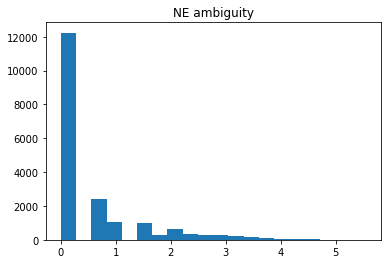

In [132]:
ambig_dict = {k:v.shape[0] for k,v in geo_dict.items()}
# plot histogram
plt.hist([np.log(x+1) for x in ambig_dict.values()], bins=20)
plt.title('NE ambiguity')
plt.show()

Boo, long distribution. Let's try to do something with this anyway.

In [133]:
from unidecode import unidecode
# compute P(descriptor) for all NEs with > min 
min_NE_count = 3
combined_tag_data_NE_flat_valid.loc[:, 'NE_fixed'] = combined_tag_data_NE_flat_valid.loc[:, 'NE'].apply(lambda x: unidecode(x[0].lower().replace('_', ' ')))
NE_descriptor_probs = []
for NE_i, NE_data_i in combined_tag_data_NE_flat_valid.groupby('NE_fixed'):
    if(NE_data_i.shape[0] > min_NE_count):
        NE_descriptor_prob_i = NE_data_i.loc[:, 'has_descriptor'].sum() / NE_data_i.shape[0]
        NE_descriptor_probs.append((NE_i, NE_descriptor_prob_i))
NE_descriptor_probs = pd.Series(dict(NE_descriptor_probs))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


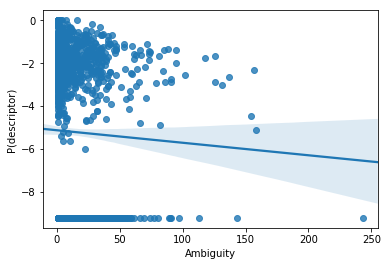

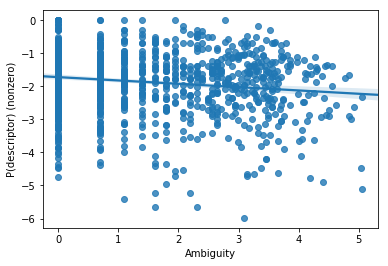

ambiguity vs. P(descriptor) = -0.144 (p=3.163E-06)


In [140]:
import seaborn as sns
from scipy.stats import pearsonr
## all vals
NE_ambig_vals = [ambig_dict[x] for x in NE_descriptor_probs.index]
sns.regplot(NE_ambig_vals, np.log(NE_descriptor_probs+1e-4))
plt.xlabel('Ambiguity')
plt.ylabel('P(descriptor)')
plt.show()
## only non-zero prob vals
NE_descriptor_probs_nonzero = np.log(NE_descriptor_probs[NE_descriptor_probs > 0.]+1e-4)
NE_ambig_vals_1 = [np.log(ambig_dict[x]) for x in NE_descriptor_probs_nonzero.index]
sns.regplot(NE_ambig_vals_1, NE_descriptor_probs_nonzero)
plt.xlabel('Ambiguity')
plt.ylabel('P(descriptor) (nonzero)')
plt.show()
correl, pval = pearsonr(NE_ambig_vals_1, NE_descriptor_probs_nonzero)
print('ambiguity vs. P(descriptor) = %.3f (p=%.3E)'%(correl, pval))

On the one hand, the effect is opposite of what we expect. On the other hand, maybe "ambiguity" here is really the same thing as `max_pop` and `max_names`, because the larger a set of names, the larger chance it has of containing a really high value for population/name.

### Regression: predicting descriptor status
Now let's try predicting descriptor on all valid NEs (i.e. at least 1 occurrence with/without descriptor) with some good old logistic regression.

- $D \sim max\_pop + max\_name + time + dist\_from\_epicenter + RT + ???$ 

We will need to balance this data 50/50, if possible by matching on each NE, to avoid class imbalance.

In [121]:
## add time 
descriptor_pred_data = pd.merge(combined_tag_data_NE_flat_valid, combined_tag_data_NE_flat_time.loc[:, ['id', 'date_stamp_bin']], on='id', how='left')
## add max_pop, max_name
descriptor_pred_data.loc[:, 'max_pop'] = descriptor_pred_data.loc[:, 'NE_fixed'].apply(lambda x: max_pop_dict[x])
descriptor_pred_data.loc[:, 'max_names'] = descriptor_pred_data.loc[:, 'NE_fixed'].apply(lambda x: max_name_dict[x])
# log-scale for later
descriptor_pred_data.loc[:, 'max_pop_log'] = np.log(descriptor_pred_data.loc[:, 'max_pop']+1.)
descriptor_pred_data.loc[:, 'max_names_log'] = np.log(descriptor_pred_data.loc[:, 'max_names']+1.)
print(combined_tag_data_NE_flat_valid.shape[0])
print(descriptor_pred_data.shape[0])
display(descriptor_pred_data.head())

167228
170140


,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,date_stamp,NE_fixed,date_stamp_bin,max_pop,max_names,max_pop_log,max_names_log
0,914098594285867009,RT @peterdaou: When Trump attacks San Juan's m...,maria,"(San_Juan, LOCATION)",True,False,1.506773e+09,san juan,3,431285,58,12.974527,4.077537
1,914098850125754368,RT @kharyp: The petty thin skinned #DonaldTrum...,maria,"(San_Juan, LOCATION)",True,False,1.506773e+09,san juan,3,431285,58,12.974527,4.077537
2,914100758550843393,RT @johnlundin: Unbelievable! This from the Pr...,maria,"(San_Juan, LOCATION)",True,False,1.506774e+09,san juan,3,431285,58,12.974527,4.077537
3,914106160780804096,"RT @will_c_fischer: .@realDonaldTrump, the rev...",maria,"(San_Juan, LOCATION)",True,False,1.506775e+09,san juan,3,431285,58,12.974527,4.077537
4,914115849635745792,RT @Mitch__Roy: The mayor of San Juan is compl...,maria,"(San_Juan, LOCATION)",True,False,1.506777e+09,san juan,3,431285,58,12.974527,4.077537


In [129]:
from statsmodels.formula.api import logit, ols, GLM
from sklearn.preprocessing import StandardScaler
print('P(descriptor) = %.3f'%(descriptor_pred_data.loc[:, 'has_descriptor'].sum() / descriptor_pred_data.shape[0]))
dep_var = 'has_descriptor_int'
importance_stat_names = ['max_pop_log', 'max_names_log']
scaler = StandardScaler()
descriptor_pred_data_norm = descriptor_pred_data.copy()
ind_vars = ['date_stamp_bin', 'C(data_name_fixed)'] + importance_stat_names
ind_vars_quant = ['date_stamp_bin'] + importance_stat_names
# Z-scale
for i in ind_vars_quant:
    descriptor_pred_data_norm.loc[:, i] = scaler.fit_transform(descriptor_pred_data_norm.loc[:, i].values.reshape(-1,1))
## combined regression
ind_vars = ind_vars = ['date_stamp_bin', 'C(data_name_fixed)'] + importance_stat_names
model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=descriptor_pred_data_norm)
res = model.fit()
print('joint model')
print(res.summary())
## per-stat regression (avoid collinearity??)
for importance_stat_name in importance_stat_names:
    print('testing stat %s'%(importance_stat_name))
    ind_vars = ['date_stamp_bin', importance_stat_name, 'C(data_name_fixed)'] # tested C(date_stamp_bin), linear effect
    ## balance 0: all data
    # model = GLM(formula)
    # normalize independent variables!!
    model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=descriptor_pred_data_norm)
    res = model.fit()
    print(res.summary())
## joint model with interaction
descriptor_pred_data_norm = descriptor_pred_data.copy()
for i in ind_vars_quant:
    descriptor_pred_data_norm.loc[:, i] = scaler.fit_transform(descriptor_pred_data_norm.loc[:, i].values.reshape(-1,1))
ind_vars = ind_vars = ['date_stamp_bin', 'C(data_name_fixed)'] + importance_stat_names + ['*'.join(importance_stat_names)]
model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=descriptor_pred_data_norm)
res = model.fit()
print('joint model with interaction')
print(res.summary())

P(descriptor) = 0.101


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.313165
         Iterations 6
joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:               170140
Model:                          Logit   Df Residuals:                   170132
Method:                           MLE   Df Model:                            7
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.04419
Time:                        14:32:00   Log-Likelihood:                -53282.
converged:                       True   LL-Null:                       -55746.
                                        LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.2177      0.026    -47

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.302581
         Iterations 7
joint model with interaction
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:               170140
Model:                          Logit   Df Residuals:                   170131
Method:                           MLE   Df Model:                            8
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.07650
Time:                        14:32:04   Log-Likelihood:                -51481.
converged:                       True   LL-Null:                       -55746.
                                        LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.1624 

- Differences between crises: fewer descriptors in Harvey, Irma, more in Michael, Florence.
- More time = more descriptors => could be due to greater proliferation of specific locations.
- Pop/names are correlated but more pop/name = fewer descriptors.

In [126]:
# same unbalanced test but for each separate event
for data_name_k, data_k in descriptor_pred_data.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_k))
    print('P(descriptor) = %.3f'%(data_k.loc[:, 'has_descriptor'].sum() / data_k.shape[0]))
    dep_var = 'has_descriptor_int'
    data_k.loc[:, dep_var] = data_k.loc[:, 'has_descriptor'].astype(int)
    importance_stat_names = ['max_pop_log', 'max_names_log']
    scaler = StandardScaler()
    data_k_norm = data_k.copy()
    ind_vars = ['date_stamp_bin'] + importance_stat_names
    ind_vars_quant = ['date_stamp_bin'] + importance_stat_names
    # log-scale importance stats
    for i in importance_stat_names:
        data_k_norm.loc[:, i] = np.log(data_k_norm.loc[:, i].values+1)
    # Z-scale
    for i in ind_vars_quant:
        data_k_norm.loc[:, i] = scaler.fit_transform(data_k_norm.loc[:, i].values.reshape(-1,1))
    ## combined regression
    model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=data_k_norm)
    res = model.fit()
    print('%s joint model'%(data_name_k))
    print(res.summary())
    ## per-stat regression (avoid collinearity??)
    for importance_stat_name in importance_stat_names:
        print('%s %s model'%(data_name_k, importance_stat_name))
        ind_vars = ['date_stamp_bin', importance_stat_name, 'C(data_name_fixed)'] # tested C(date_stamp_bin), linear effect
        ## balance 0: all data
        # model = GLM(formula)
        # normalize independent variables!!
        model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=data_k_norm)
        res = model.fit()
        print(res.summary())

testing data florence
P(descriptor) = 0.240


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.545870
         Iterations 6
florence joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 9995
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.01032
Time:                        12:59:38   Log-Likelihood:                -5456.0
converged:                       True   LL-Null:                       -5512.9
                                        LLR p-value:                 1.651e-24
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1680      0.024    -49.110      0.000      -1.215      -1.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.273393
         Iterations 7
harvey joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                74029
Model:                          Logit   Df Residuals:                    74025
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.05463
Time:                        12:59:42   Log-Likelihood:                -20239.
converged:                       True   LL-Null:                       -21409.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5161      0.015   -172.715      0.000      -2.545      -2.48

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.294420
         Iterations 7
irma joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                70327
Model:                          Logit   Df Residuals:                    70323
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.01044
Time:                        12:59:46   Log-Likelihood:                -20706.
converged:                       True   LL-Null:                       -20924.
                                        LLR p-value:                 2.038e-94
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3704      0.014   -173.368      0.000      -2.397      -2.344


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.296916
         Iterations 7
maria joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 7228
Model:                          Logit   Df Residuals:                     7224
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.03925
Time:                        12:59:50   Log-Likelihood:                -2146.1
converged:                       True   LL-Null:                       -2233.8
                                        LLR p-value:                 8.969e-38
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3986      0.045    -53.197      0.000      -2.487      -2.310

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Optimization terminated successfully.
         Current function value: 0.495096
         Iterations 6
michael joint model
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 8561
Model:                          Logit   Df Residuals:                     8557
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2019   Pseudo R-squ.:                 0.01277
Time:                        12:59:53   Log-Likelihood:                -4238.5
converged:                       True   LL-Null:                       -4293.4
                                        LLR p-value:                 1.287e-23
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.4033      0.027    -51.080      0.000      -1.457      -1.3

Let's do the same thing but try to balance this time.

mean coefficients


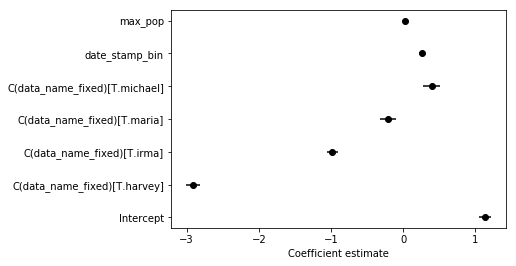

mean coefficients


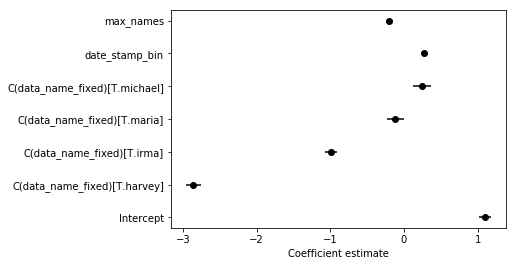

In [396]:
np.random.seed(123)
## balance 1: randomly sample for balanced data
## compute mean/std 
random_sample_iters = 50
for importance_stat_name in importance_stat_names:
    ind_vars = ['date_stamp_bin', importance_stat_name, 'C(data_name_fixed)']
    sample_coeffs = []
    sample_errs = []
    for i in range(random_sample_iters):
        descriptor_pred_data_i = descriptor_pred_data_norm.copy()
        # sample on dependent var
        g = descriptor_pred_data_i.groupby(dep_var)
        descriptor_pred_data_i = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
        model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=descriptor_pred_data_i)
        res = model.fit(disp=False)
        # get coefficients
        coeffs_i = pd.DataFrame(res.params)
        stderr_i = pd.DataFrame(res.bse)
        sample_coeffs.append(coeffs_i)
        sample_errs.append(stderr_i)
    sample_coeffs = pd.concat(sample_coeffs, axis=1).transpose()
    sample_errs = pd.concat(sample_errs, axis=1).transpose()
    sample_coeff_mean = sample_coeffs.mean(axis=0)
    sample_coeff_err = sample_errs.mean(axis=0)
    print('mean coefficients')
    # plot coefficients as horizontal scatter plot
    Y = np.arange(len(sample_coeff_mean))
    plt.scatter(sample_coeff_mean, Y, color='k')
    plt.errorbar(sample_coeff_mean, Y, xerr=sample_coeff_err, ls='', color='k')
    plt.yticks(Y, sample_coeff_mean.index)
    plt.xlabel('Coefficient estimate')
    plt.show()

testing data florence
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1776
Model:                          Logit   Df Residuals:                     1773
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.02243
Time:                        18:38:25   Log-Likelihood:                -1203.4
converged:                       True   LL-Null:                       -1231.0
                                        LLR p-value:                 1.023e-12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3886      0.073     -5.304      0.000      -0.532      -0.245
date_stamp_bin     0.4850      0.069      6.985      0.000       0.349       0.62

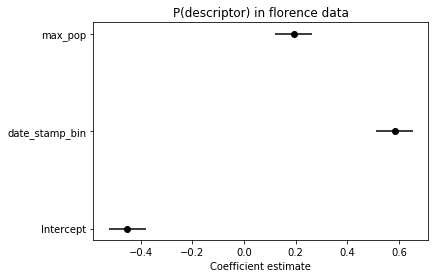

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1776
Model:                          Logit   Df Residuals:                     1773
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.02995
Time:                        18:38:27   Log-Likelihood:                -1194.2
converged:                       True   LL-Null:                       -1231.0
                                        LLR p-value:                 9.681e-17
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4030      0.074     -5.426      0.000      -0.549      -0.257
date_stamp_bin     0.5568      0.071      7.878      0.000       0.418       0.695
max_names          0

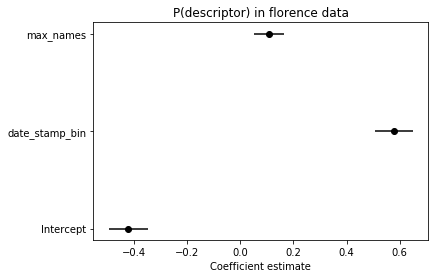

testing data harvey
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                  798
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                0.008243
Time:                        18:38:28   Log-Likelihood:                -548.57
converged:                       True   LL-Null:                       -553.13
                                        LLR p-value:                   0.01047
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0612      0.078     -0.786      0.432      -0.214       0.091
date_stamp_bin    -0.1102      0.074     -1.497      0.134      -0.254       0.034


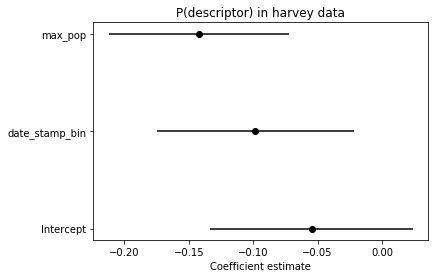

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                  798
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.05192
Time:                        18:38:32   Log-Likelihood:                -524.41
converged:                       True   LL-Null:                       -553.13
                                        LLR p-value:                 3.363e-13
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0619      0.080     -0.770      0.441      -0.220       0.096
date_stamp_bin    -0.0586      0.079     -0.744      0.457      -0.213       0.096
max_names         -0

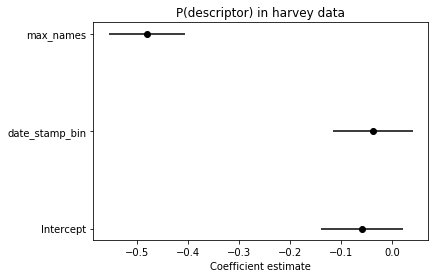

testing data irma
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 4144
Model:                          Logit   Df Residuals:                     4141
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.06908
Time:                        18:38:35   Log-Likelihood:                -2674.0
converged:                       True   LL-Null:                       -2872.4
                                        LLR p-value:                 6.713e-87
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8749      0.061    -14.285      0.000      -0.995      -0.755
date_stamp_bin     1.2417      0.072     17.170      0.000       1.100       1.383
ma

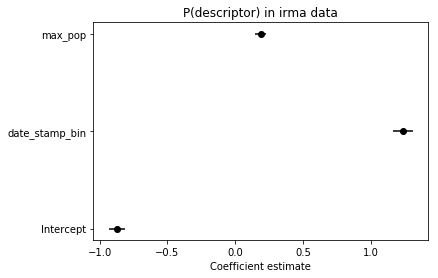

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 4144
Model:                          Logit   Df Residuals:                     4141
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.06634
Time:                        18:38:37   Log-Likelihood:                -2681.8
converged:                       True   LL-Null:                       -2872.4
                                        LLR p-value:                 1.726e-83
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8580      0.061    -14.151      0.000      -0.977      -0.739
date_stamp_bin     1.2067      0.071     16.946      0.000       1.067       1.346
max_names         -0

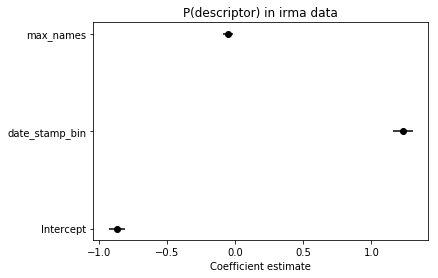

testing data maria
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1118
Model:                          Logit   Df Residuals:                     1115
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.03448
Time:                        18:38:40   Log-Likelihood:                -748.22
converged:                       True   LL-Null:                       -774.94
                                        LLR p-value:                 2.487e-12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0707      0.080      0.879      0.380      -0.087       0.228
date_stamp_bin    -0.4160      0.064     -6.482      0.000      -0.542      -0.290
m

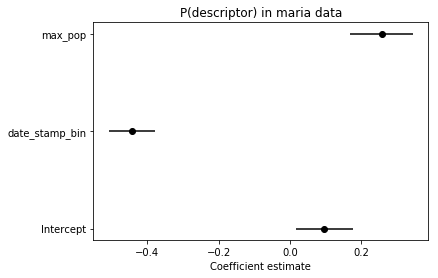

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1118
Model:                          Logit   Df Residuals:                     1115
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.03688
Time:                        18:38:41   Log-Likelihood:                -746.36
converged:                       True   LL-Null:                       -774.94
                                        LLR p-value:                 3.874e-13
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2449      0.071      3.460      0.001       0.106       0.384
date_stamp_bin    -0.4682      0.066     -7.135      0.000      -0.597      -0.340
max_names         -0

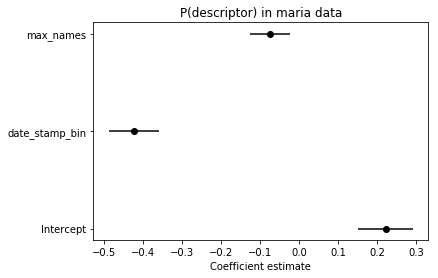

testing data michael
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1482
Model:                          Logit   Df Residuals:                     1479
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                0.007604
Time:                        18:38:42   Log-Likelihood:                -1019.4
converged:                       True   LL-Null:                       -1027.2
                                        LLR p-value:                 0.0004053
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0229      0.063      0.365      0.715      -0.100       0.146
date_stamp_bin     0.1189      0.049      2.421      0.015       0.023       0.215

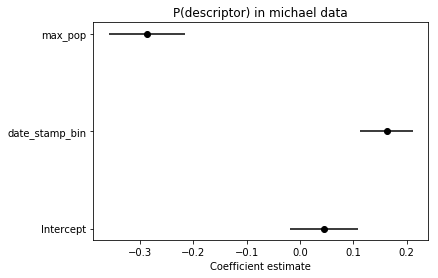

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1482
Model:                          Logit   Df Residuals:                     1479
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.03645
Time:                        18:38:44   Log-Likelihood:                -989.80
converged:                       True   LL-Null:                       -1027.2
                                        LLR p-value:                 5.500e-17
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1197      0.069     -1.730      0.084      -0.255       0.016
date_stamp_bin     0.1997      0.050      3.991      0.000       0.102       0.298
max_names         -0

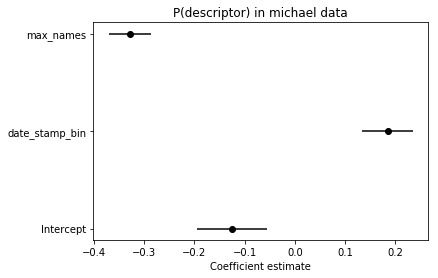

In [401]:
# same thing, but different regression for each data set
np.random.seed(123)
random_sample_iters = 50
for data_name_i, descriptor_data_i in descriptor_pred_data_norm.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    for importance_stat_name in importance_stat_names:
        ind_vars = ['date_stamp_bin', importance_stat_name]
        sample_coeffs = []
        sample_errs = []
        for i in range(random_sample_iters):
            descriptor_pred_data_i = descriptor_data_i.copy()
            # sample on dependent var
            g = descriptor_pred_data_i.groupby(dep_var)
            descriptor_pred_data_i = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
            model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=descriptor_pred_data_i)
            res = model.fit(disp=False)
            if(i == 0):
                print('results summary')
                print(res.summary())
            # get coefficients
            coeffs_i = pd.DataFrame(res.params)
            stderr_i = pd.DataFrame(res.bse)
            sample_coeffs.append(coeffs_i)
            sample_errs.append(stderr_i)
        sample_coeffs = pd.concat(sample_coeffs, axis=1).transpose()
        sample_errs = pd.concat(sample_errs, axis=1).transpose()
        sample_coeff_mean = sample_coeffs.mean(axis=0)
        sample_coeff_err = sample_errs.mean(axis=0)
        # plot coefficients as horizontal scatter plot
        Y = np.arange(len(sample_coeff_mean))
        plt.scatter(sample_coeff_mean, Y, color='k')
        plt.errorbar(sample_coeff_mean, Y, xerr=sample_coeff_err, ls='', color='k')
        plt.yticks(Y, sample_coeff_mean.index)
        plt.xlabel('Coefficient estimate')
        plt.title('P(descriptor) in %s data'%(data_name_i))
        plt.show()

In [389]:
# next step: how many NEs occur with/without descriptor?
NE_descriptor_counts = descriptor_pred_data_norm.groupby('NE_fixed').apply(lambda x: [x.loc[:, 'has_descriptor'].sum(), (1-x.loc[:, 'has_descriptor']).sum()])
NE_descriptor_counts = pd.DataFrame(NE_descriptor_counts)
NE_descriptor_counts.loc[:, 'has_descriptor'] = NE_descriptor_counts.iloc[:, 0].apply(lambda x: x[0])
NE_descriptor_counts.loc[:, 'not_has_descriptor'] = NE_descriptor_counts.iloc[:, 0].apply(lambda x: x[1])
print('%d unique NEs with/without descriptor'%(len(NE_descriptor_counts[(NE_descriptor_counts.loc[:, 'has_descriptor']>0) &  
                                                                        (NE_descriptor_counts.loc[:, 'not_has_descriptor']>0)])))

649 unique NEs with/without descriptor


First test: across all data.

testing data michael
649 valid NEs with 111350 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 8182
Model:                          Logit   Df Residuals:                     8175
Method:                           MLE   Df Model:                            6
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.01034
Time:                        11:24:55   Log-Likelihood:                -5612.7
converged:                       True   LL-Null:                       -5671.3
                                        LLR p-value:                 5.958e-23
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0192      0.056     -0.340      0.734      -0.129       0.091
C(data

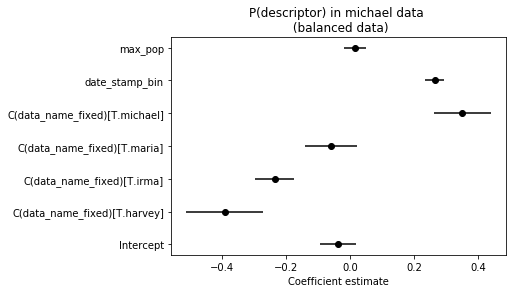

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 8182
Model:                          Logit   Df Residuals:                     8175
Method:                           MLE   Df Model:                            6
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.01186
Time:                        11:30:44   Log-Likelihood:                -5604.1
converged:                       True   LL-Null:                       -5671.3
                                        LLR p-value:                 1.462e-26
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0285      0.057     -0.502      0.615      -0.140       0.083
C(data_name_fixed)[T.harvey]     -0.4366      0.121     -3

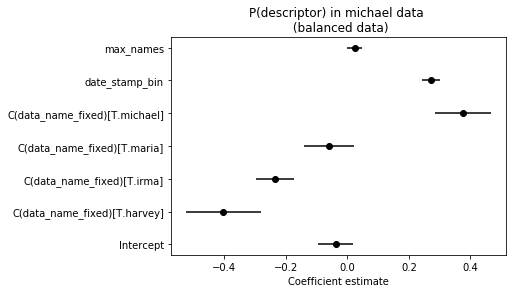

In [406]:
## balance 2.1: all data
np.random.seed(123)
random_sample_iters = 50
print('testing data %s'%(data_name_i))
# restrict to NEs with/without descriptor
NE_descriptor_counts = descriptor_pred_data_norm.groupby('NE_fixed').apply(lambda x: [x.loc[:, 'has_descriptor'].sum(), (1-x.loc[:, 'has_descriptor']).sum()])
NE_descriptor_counts = pd.DataFrame(NE_descriptor_counts)
NE_descriptor_counts.loc[:, 'has_descriptor'] = NE_descriptor_counts.iloc[:, 0].apply(lambda x: x[0])
NE_descriptor_counts.loc[:, 'not_has_descriptor'] = NE_descriptor_counts.iloc[:, 0].apply(lambda x: x[1])
# find NEs with/without descriptor
valid_NEs = NE_descriptor_counts[(NE_descriptor_counts.loc[:, 'has_descriptor']>0) &
                                 (NE_descriptor_counts.loc[:, 'not_has_descriptor']>0)].index
descriptor_data_valid = descriptor_pred_data_norm[descriptor_pred_data_norm.loc[:, 'NE_fixed'].isin(valid_NEs)]
print('%d valid NEs with %d data'%(len(valid_NEs), descriptor_data_valid.shape[0]))
#     print('%d/%d balanced data'%(balanced_data_i.shape[0], descriptor_data_valid.shape[0]))
for importance_stat_name in importance_stat_names:
    ind_vars = ['date_stamp_bin', importance_stat_name, 'C(data_name_fixed)']
    sample_coeffs = []
    sample_errs = []
    for i in range(random_sample_iters):
        # sample data to balance 
        balanced_data_i = []
        for NE_j, NE_data_j in descriptor_data_valid.groupby('NE_fixed'):
            g = NE_data_j.groupby(dep_var)
            g_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
            balanced_data_i.append(g_data)
        balanced_data_i = pd.concat(balanced_data_i, axis=0)
        model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=balanced_data_i)
        res = model.fit(disp=False)
        if(i == 0):
            print('results summary')
            print(res.summary())
        # get coefficients
        coeffs_i = pd.DataFrame(res.params)
        stderr_i = pd.DataFrame(res.bse)
        sample_coeffs.append(coeffs_i)
        sample_errs.append(stderr_i)
    sample_coeffs = pd.concat(sample_coeffs, axis=1).transpose()
    sample_errs = pd.concat(sample_errs, axis=1).transpose()
    sample_coeff_mean = sample_coeffs.mean(axis=0)
    sample_coeff_err = sample_errs.mean(axis=0)
    # plot coefficients as horizontal scatter plot
    Y = np.arange(len(sample_coeff_mean))
    plt.scatter(sample_coeff_mean, Y, color='k')
    plt.errorbar(sample_coeff_mean, Y, xerr=sample_coeff_err, ls='', color='k')
    plt.yticks(Y, sample_coeff_mean.index)
    plt.xlabel('Coefficient estimate')
    plt.title('P(descriptor) in %s data \n (balanced data)'%(data_name_i))
    plt.show()

testing data florence
143 valid NEs with 5812 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1656
Model:                          Logit   Df Residuals:                     1653
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.02780
Time:                        10:49:37   Log-Likelihood:                -1115.9
converged:                       True   LL-Null:                       -1147.9
                                        LLR p-value:                 1.384e-14
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4584      0.079     -5.836      0.000      -0.612      -0.304
date_stamp_bin     0.5913      0.076      7.755     

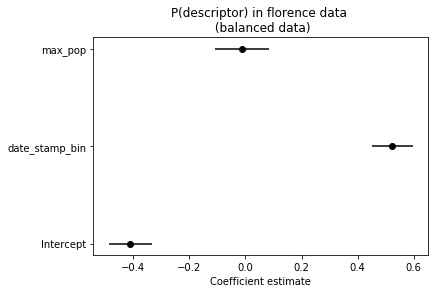

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1656
Model:                          Logit   Df Residuals:                     1653
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.01889
Time:                        10:50:50   Log-Likelihood:                -1126.2
converged:                       True   LL-Null:                       -1147.9
                                        LLR p-value:                 3.816e-10
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3889      0.078     -4.969      0.000      -0.542      -0.236
date_stamp_bin     0.4819      0.075      6.463      0.000       0.336       0.628
max_names         -0

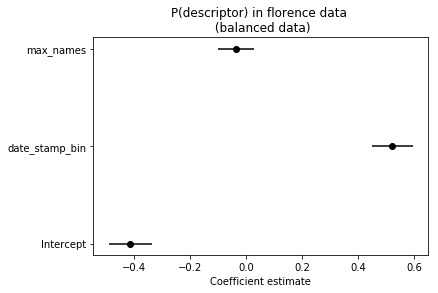

testing data harvey
25 valid NEs with 58440 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                  294
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                0.003861
Time:                        10:52:02   Log-Likelihood:                -203.00
converged:                       True   LL-Null:                       -203.79
                                        LLR p-value:                    0.4553
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0587      0.129     -0.456      0.649      -0.311       0.194
date_stamp_bin    -0.1567      0.125     -1.250      0

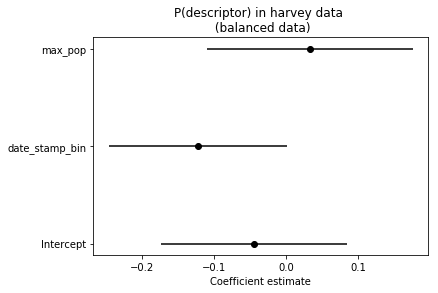

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                  294
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:               0.0009505
Time:                        10:52:17   Log-Likelihood:                -203.59
converged:                       True   LL-Null:                       -203.79
                                        LLR p-value:                    0.8239
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0321      0.135     -0.238      0.812      -0.296       0.232
date_stamp_bin    -0.0770      0.124     -0.622      0.534      -0.320       0.166
max_names          0

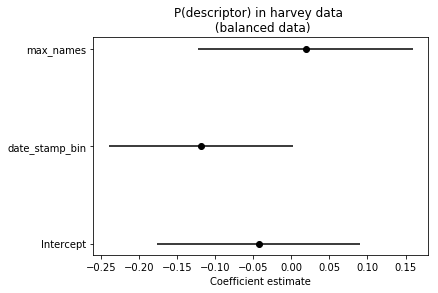

testing data irma
334 valid NEs with 31461 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 3604
Model:                          Logit   Df Residuals:                     3601
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.06741
Time:                        10:52:37   Log-Likelihood:                -2329.7
converged:                       True   LL-Null:                       -2498.1
                                        LLR p-value:                 7.347e-74
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1045      0.082    -13.551      0.000      -1.264      -0.945
date_stamp_bin     1.4637      0.096     15.238      0.

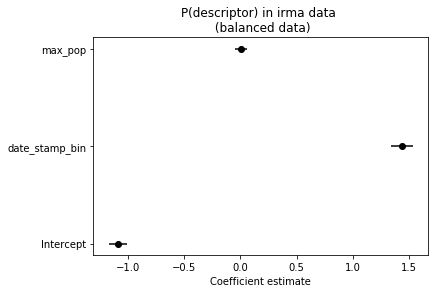

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 3604
Model:                          Logit   Df Residuals:                     3601
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.05735
Time:                        10:55:31   Log-Likelihood:                -2354.8
converged:                       True   LL-Null:                       -2498.1
                                        LLR p-value:                 5.961e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0401      0.081    -12.811      0.000      -1.199      -0.881
date_stamp_bin     1.3588      0.095     14.369      0.000       1.173       1.544
max_names          0

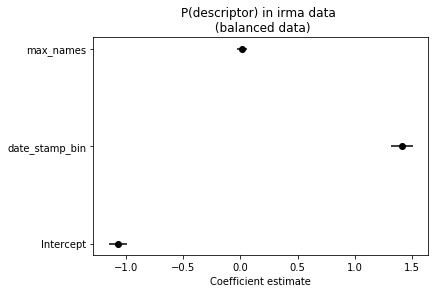

testing data maria
75 valid NEs with 5846 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1109
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.01593
Time:                        10:58:19   Log-Likelihood:                -758.50
converged:                       True   LL-Null:                       -770.78
                                        LLR p-value:                 4.668e-06
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1121      0.090      1.241      0.215      -0.065       0.289
date_stamp_bin    -0.3048      0.063     -4.859      0.0

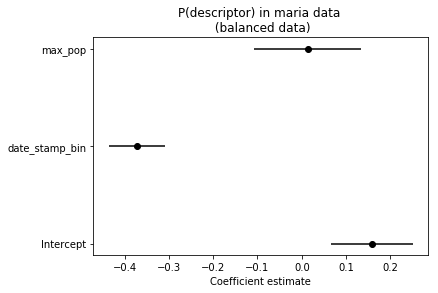

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1109
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                 0.01628
Time:                        10:58:57   Log-Likelihood:                -758.23
converged:                       True   LL-Null:                       -770.78
                                        LLR p-value:                 3.551e-06
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1272      0.067      1.902      0.057      -0.004       0.258
date_stamp_bin    -0.3095      0.063     -4.910      0.000      -0.433      -0.186
max_names          0

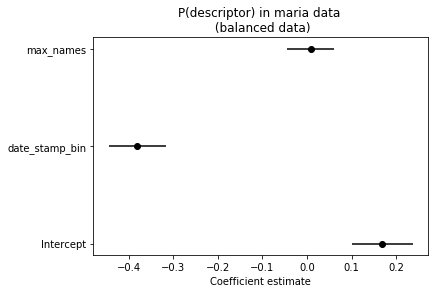

testing data michael
104 valid NEs with 4546 data
results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1414
Model:                          Logit   Df Residuals:                     1411
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                0.003525
Time:                        10:59:37   Log-Likelihood:                -976.65
converged:                       True   LL-Null:                       -980.11
                                        LLR p-value:                   0.03158
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0819      0.066      1.239      0.215      -0.048       0.211
date_stamp_bin     0.1332      0.051      2.620      

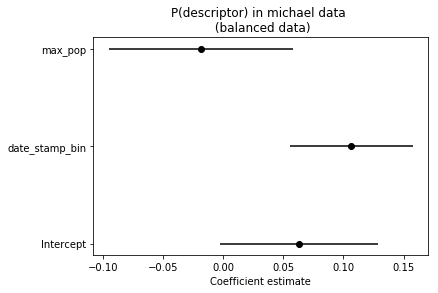

results summary
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 1414
Model:                          Logit   Df Residuals:                     1411
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                0.003296
Time:                        11:00:33   Log-Likelihood:                -976.88
converged:                       True   LL-Null:                       -980.11
                                        LLR p-value:                   0.03954
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0692      0.074      0.931      0.352      -0.076       0.215
date_stamp_bin     0.1301      0.051      2.534      0.011       0.029       0.231
max_names         -0

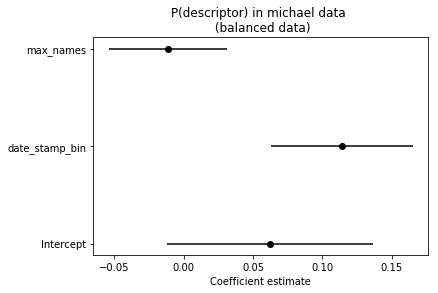

In [405]:
## balance 2.2: separate data sets
np.random.seed(123)
random_sample_iters = 50
min_NE_count = 30
for data_name_i, descriptor_data_i in descriptor_pred_data_norm.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_i))
    # restrict to NEs with/without descriptor
    NE_descriptor_counts_i = descriptor_data_i.groupby('NE_fixed').apply(lambda x: [x.loc[:, 'has_descriptor'].sum(), (1-x.loc[:, 'has_descriptor']).sum()])
    NE_descriptor_counts_i = pd.DataFrame(NE_descriptor_counts_i)
    NE_descriptor_counts_i.loc[:, 'has_descriptor'] = NE_descriptor_counts_i.iloc[:, 0].apply(lambda x: x[0])
    NE_descriptor_counts_i.loc[:, 'not_has_descriptor'] = NE_descriptor_counts_i.iloc[:, 0].apply(lambda x: x[1])
    # find NEs with/without descriptor
    valid_NEs = NE_descriptor_counts_i[(NE_descriptor_counts_i.loc[:, 'has_descriptor']>0) &
                                       (NE_descriptor_counts_i.loc[:, 'not_has_descriptor']>0)].index
    descriptor_data_i_valid = descriptor_data_i[descriptor_data_i.loc[:, 'NE_fixed'].isin(valid_NEs)]
    print('%d valid NEs with %d data'%(len(valid_NEs), descriptor_data_i_valid.shape[0]))
#     print('%d/%d balanced data'%(balanced_data_i.shape[0], descriptor_data_i_valid.shape[0]))
    for importance_stat_name in importance_stat_names:
        ind_vars = ['date_stamp_bin', importance_stat_name]
        sample_coeffs = []
        sample_errs = []
        for i in range(random_sample_iters):
            # sample data to balance 
            balanced_data_i = []
            for NE_j, NE_data_j in descriptor_data_i_valid.groupby('NE_fixed'):
                g = NE_data_j.groupby(dep_var)
                g_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
                balanced_data_i.append(g_data)
            balanced_data_i = pd.concat(balanced_data_i, axis=0)
            model = logit(formula='%s ~ %s'%(dep_var, '+'.join(ind_vars)), data=balanced_data_i)
            res = model.fit(disp=False)
            if(i == 0):
                print('results summary')
                print(res.summary())
            # get coefficients
            coeffs_i = pd.DataFrame(res.params)
            stderr_i = pd.DataFrame(res.bse)
            sample_coeffs.append(coeffs_i)
            sample_errs.append(stderr_i)
        sample_coeffs = pd.concat(sample_coeffs, axis=1).transpose()
        sample_errs = pd.concat(sample_errs, axis=1).transpose()
        sample_coeff_mean = sample_coeffs.mean(axis=0)
        sample_coeff_err = sample_errs.mean(axis=0)
        # plot coefficients as horizontal scatter plot
        Y = np.arange(len(sample_coeff_mean))
        plt.scatter(sample_coeff_mean, Y, color='k')
        plt.errorbar(sample_coeff_mean, Y, xerr=sample_coeff_err, ls='', color='k')
        plt.yticks(Y, sample_coeff_mean.index)
        plt.xlabel('Coefficient estimate')
        plt.title('P(descriptor) in %s data \n (balanced data)'%(data_name_i))
        plt.show()

OK! Overall not a lot of great results:

- Florence: time=positive, importance=negative (weak)
- Harvey: nothing
- Irma: time=positive, importance=negative (weak)
- Maria: time=negative, importance=positive (weak)
- Michael: time=positive, importance=negative (weak)

### Fixed effects regression
Let's add a fixed effect for each location name.

In [150]:
# save for posterity JUST IN CASE
descriptor_pred_data.to_csv('../../data/mined_tweets/descriptor_pred_data.gz', sep='\t', compression='gzip', index=False)

In [250]:
%%capture logit_output
from linearmodels.panel import PanelOLS # this is OLS not logit!! ugh
from statsmodels.discrete.conditional_models import ConditionalLogit
from statsmodels.discrete.discrete_model import Logit
np.random.seed(123)
min_NE_count_regression = 10
dep_var = 'has_descriptor_int'
importance_stat_names = ['max_pop_log', 'max_names_log']
ind_vars = ['date_stamp_bin'] + importance_stat_names
ind_vars_quant = ['date_stamp_bin'] + importance_stat_names
fixed_regression_models = {}
for data_name_k, data_k in descriptor_pred_data.groupby('data_name_fixed'):
    print('testing data %s'%(data_name_k))
    print('P(descriptor) = %.3f'%(data_k.loc[:, 'has_descriptor'].sum() / data_k.shape[0]))    
    data_k.loc[:, dep_var] = data_k.loc[:, 'has_descriptor'].astype(int)
    scaler = StandardScaler()
    data_k_norm = data_k.copy()
    ## TODO: restrict to consistent NEs?? i.e. at least one success/fail
    valid_NE_k = data_k_norm.groupby('NE_fixed').apply(lambda x: (x.loc[:, dep_var].var() > 0.) & (x.shape[0] >= min_NE_count_regression))
    valid_NE_k = valid_NE_k[valid_NE_k].index
    data_k_norm = data_k_norm[data_k_norm.loc[:, 'NE_fixed'].isin(valid_NE_k)]
    print('%d/%d data in filtered set'%(data_k_norm.shape[0], data_k.shape[0]))
    # log-scale importance stats
#     for i in importance_stat_names:
#         data_k_norm.loc[:, i] = np.log(data_k_norm.loc[:, i].values+1)
    # Z-scale
    for i in ind_vars_quant:
        data_k_norm.loc[:, i] = scaler.fit_transform(data_k_norm.loc[:, i].values.reshape(-1,1))
    ## combined regression
    # code for OLS regression
#     data_k_norm.set_index(['NE_fixed', 'date_stamp_bin'], inplace=True)
#     model = PanelOLS.from_formula('%s ~ %s + TimeEffects + EntityEffects'%(dep_var, '+'.join(importance_stat_names)), data=data_k_norm)
#     res = model.fit(cov_type='clustered', cluster_entity=True)
    # regular logit with name => categorical
    group_var = 'NE_fixed'
    # no interaction
    model = Logit.from_formula('%s ~ %s + C(%s)'%(dep_var, ' + '.join(ind_vars), group_var), data=data_k_norm)
    # with interaction
#     model = Logit.from_formula('%s ~ %s + C(%s)'%(dep_var, '+'.join(ind_vars + ['*'.join(importance_stat_names)]), group_var), data=data_k_norm)
    # conditional logit
#     group_var = 'NE_fixed'
    # cannot compute parameter covariance?? 
    # error: ValueError: need covariance of parameters for computing (unnormalized) covariances
#     data_k_norm_i = data_k_norm.head(10000)
#     model = ConditionalLogit(data_k_norm_i.loc[:, dep_var], data_k_norm_i.loc[:, ind_vars], groups=data_k_norm_i.loc[:, group_var])
    res = model.fit()
    print('%s joint model'%(data_name_k))
    print('%d params'%(len(res.params)))
    print(res.summary())
    fixed_regression_models[data_name_k] = [res, model]

In [251]:
logit_output.show()

testing data florence
P(descriptor) = 0.240
7780/9995 data in filtered set
Optimization terminated successfully.
         Current function value: 0.512579
         Iterations 8
florence joint model
110 params
                           Logit Regression Results                           
Dep. Variable:     has_descriptor_int   No. Observations:                 7780
Model:                          Logit   Df Residuals:                     7672
Method:                           MLE   Df Model:                          107
Date:                Fri, 29 Mar 2019   Pseudo R-squ.:                  0.1097
Time:                        18:38:18   Log-Likelihood:                -3987.9
converged:                       True   LL-Null:                       -4479.4
                                        LLR p-value:                1.338e-141
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py

OK! The date effects are consistently negative or insignificant, so it looks like the original positive effects that we saw for date might be driven by individual entities.

Can we plot the overall probability over time for individual entities and compare against their empirical distribution?

We can do this for the top-k NEs for each data group...BLAH.

processing florence data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


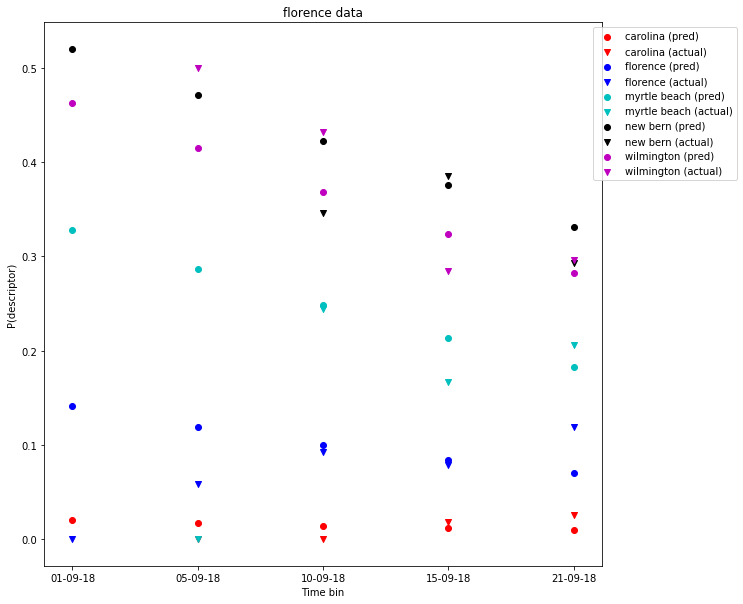

processing harvey data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


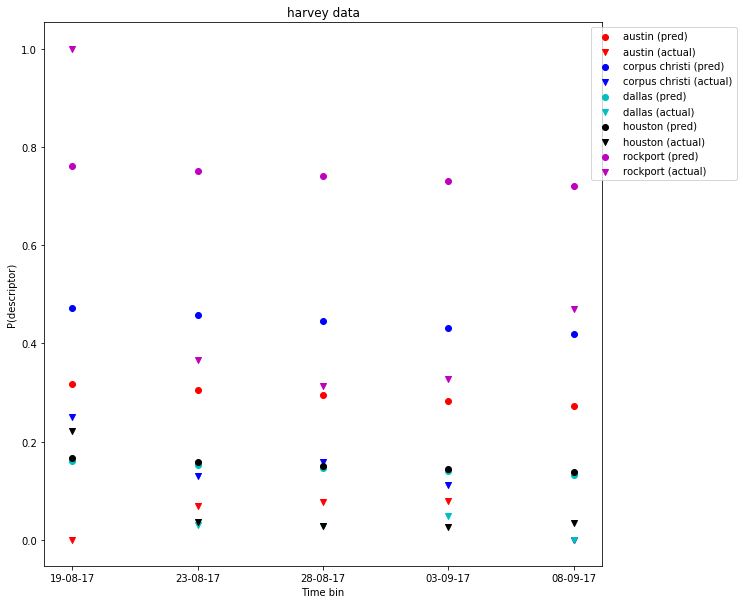

processing irma data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


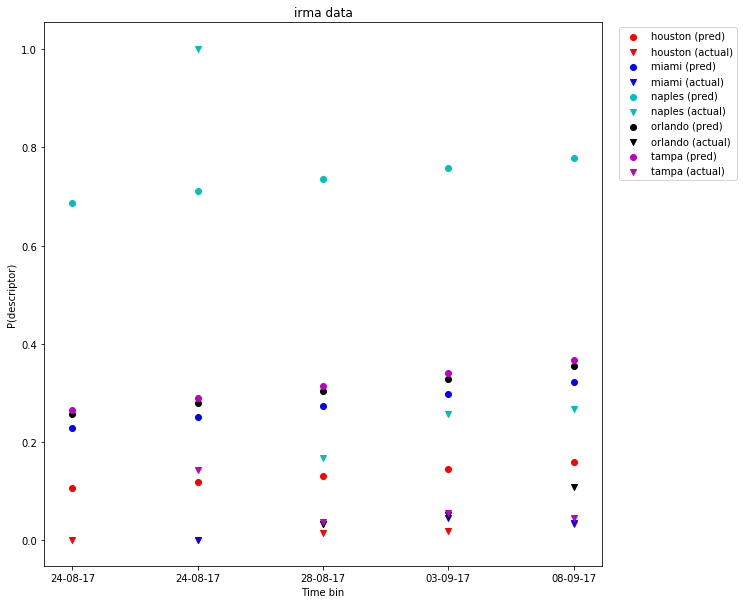

processing maria data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


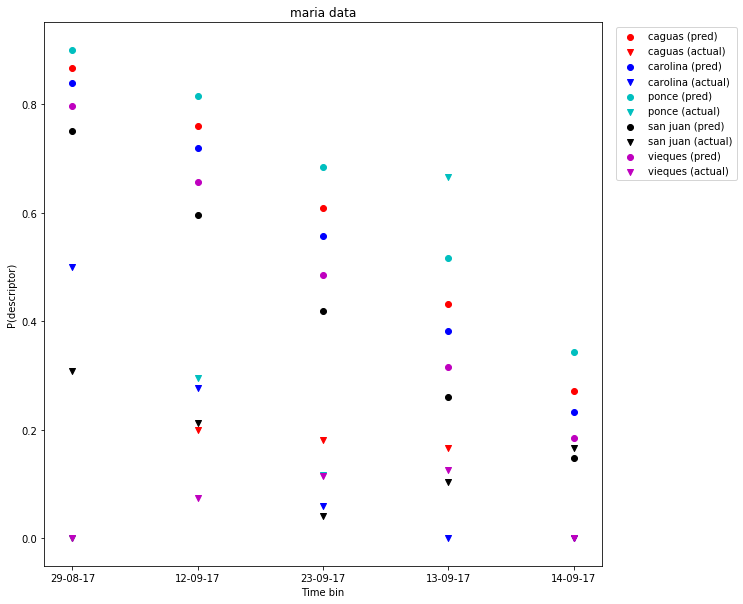

processing michael data


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


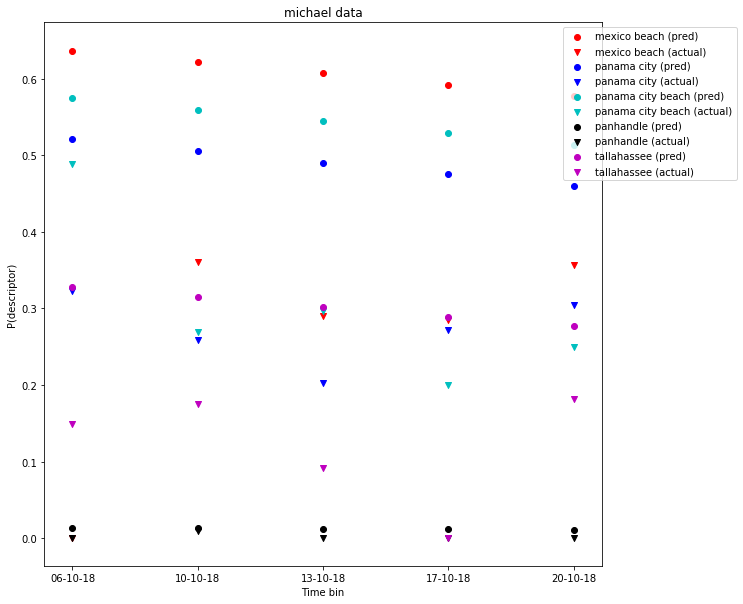

In [277]:
from itertools import cycle
from datetime import datetime
top_k = 5
time_var = 'date_stamp_bin'
raw_time_var = 'date_stamp'
ind_vars = ['max_pop_log', 'max_names_log']
importance_stat_names = ['max_pop_log', 'max_names_log']
ind_vars_quant = ['date_stamp_bin'] + importance_stat_names
dep_var = 'has_descriptor_int'
# collect all pred/empirical probs
for data_name_k, data_k in descriptor_pred_data.groupby('data_name_fixed'):
    print('processing %s data'%(data_name_k))
    orig_time_vals = sorted(data_k.loc[:, time_var].unique())
    for i in ind_vars_quant:
        data_k.loc[:, i] = scaler.fit_transform(data_k.loc[:, i].values.reshape(-1,1))
    res_k, model_k = fixed_regression_models[data_name_k]
    # get top-k data
    data_k_NE_counts = data_k.loc[:, 'NE_fixed'].value_counts().sort_values(inplace=False, ascending=False)
    data_k_top_NE_names = data_k_NE_counts.index[:top_k]
    data_k_top_NE = data_k[data_k.loc[:, 'NE_fixed'].isin(data_k_top_NE_names)]
    # compute predicted probability at each time bin
    N_time = len(time_bins)
#     time_vals = data_k.groupby(time_var).apply(lambda x: x.loc[:, 'date_stamp'].min())
    time_vals = data_k.loc[:, time_var].unique()
    # get raw time for plot
    raw_time_vals = data_k.groupby(time_var).apply(lambda x: x.loc[:, raw_time_var].min()).apply(lambda x: datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y'))
    pred_probs_k = []
    res_k_params = res_k.params
    N_params = len(res_k_params)
    time_idx = np.where(res_k.params.index==time_var)[0][0]
    NE_prob_data = []
    for data_k_j_NE, data_k_j in data_k_top_NE.groupby('NE_fixed'):
        NE_idx = np.where(res_k.params.index == 'C(NE_fixed)[T.%s]'%(data_k_j_NE))[0]
        pred_data_j = np.zeros((N_time, N_params))
        pred_data_j[:, NE_idx] = 1.
        pred_data_j[:, time_idx] = np.array(time_vals)
        for i in ind_vars:
            i_val = data_k_j.loc[:, i].values[0]
            i_idx = np.where(res_k.params.index == i)[0][0]
            pred_data_j[:, i_idx] = i_val
        # predict
        pred_prob_j = model_k.predict(res_k_params, exog=pred_data_j)
        pred_prob_j = pd.DataFrame(pd.Series(pred_prob_j, index=time_vals))
#         print('pred')
#         print(pred_prob_j)
        # compute actual
        actual_prob_j = data_k_j.groupby(time_var).apply(lambda x: x.loc[:, dep_var].sum()/x.shape[0])
        actual_prob_j = pd.DataFrame(pd.Series(actual_prob_j))
#         print('actual')
#         print(actual_prob_j)
        prob_data_j = pd.concat([pred_prob_j, actual_prob_j], axis=1)
#         print('combined')
#         print(prob_data_j)
        prob_data_j.columns = ['pred_prob', 'actual_prob']
        prob_data_j.index = np.arange(prob_data_j.shape[0])
        # add NE, time bins
        prob_data_j.loc[:, 'NE'] = data_k_j_NE
        prob_data_j.loc[:, time_var] = orig_time_vals
#         print('final')
#         print(prob_data_j)
        NE_prob_data.append(prob_data_j)
    NE_prob_data = pd.concat(NE_prob_data, axis=0)
#     display(NE_prob_data)
    # plot predicted vs. empirical
    # triangle = actual, circle = pred
    plt.figure(figsize=(10, 10))
    colors = cycle(['r', 'b', 'c', 'k', 'm'])
    for NE_j, prob_j in NE_prob_data.groupby('NE'):
        prob_j_valid = prob_j[~prob_j.loc[:, 'actual_prob'].apply(lambda x: np.isnan(x))]
        c_j = next(colors)
        # pred
        plt.scatter(prob_j.loc[:, time_var], prob_j.loc[:, 'pred_prob'], marker='o', c=c_j, label='%s (pred)'%(NE_j))
        plt.scatter(prob_j_valid.loc[:, time_var], prob_j_valid.loc[:, 'actual_prob'], marker='v', c=c_j, label='%s (actual)'%(NE_j))
    plt.legend(loc='upper right', bbox_to_anchor=[1.25, 1.])
    plt.title('%s data'%(data_name_k))
    plt.xlabel('Time bin')
    plt.ylabel('P(descriptor)')
    plt.xticks(orig_time_vals, raw_time_vals)
    plt.show()

In [165]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)
# MultiIndex, entity - time
data = data.set_index(['firm','year'])
print(data.head())
from linearmodels import PanelOLS
mod = PanelOLS.from_formula('invest ~ value + capital + EntityEffects', data)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                        invest   value  capital
firm              year                         
b'General Motors' 1935   317.6  3078.5      2.8
                  1936   391.8  4661.7     52.6
                  1937   410.6  5387.1    156.9
                  1938   257.7  2792.2    209.2
                  1939   330.8  4313.2    203.4
                          PanelOLS Estimation Summary                           
Dep. Variable:                 invest   R-squared:                        0.7667
Estimator:                   PanelOLS   R-squared (Between):              0.8223
No. Observations:                 220   R-squared (Within):               0.7667
Date:                Thu, Mar 28 2019   R-squared (Overall):              0.8132
Time:                        18:55:10   Log-likelihood                   -1167.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      340.08
Entities:       

### Lagged prediction
Let's try predicting the presence of a descriptor at t based on NE frequency at t-1

### Linguistic model
Let's compare to a typical BOW model: can we predict descriptor status based on the linguistic context, minus the NE string and the descriptor (if available)?

# Old code

### Entity cooccurrence

Let's add cooccurrence as a weaker marker of information status: e.g. if "Houston" cooccurs with "Texas" somewhere in the tweet, then we assume that the authors is treating "Houston" as new information. This will catch a bigger range of locations, e.g. non-cities that aren't adjacent to state mentions in text.

To do this right, we'll need to map each NE location mentioned to a valid list of states/countries that could be used to describe it...yikes.

In [111]:
# let's make sure these are reasonable
combined_tag_data_NE_flat[combined_tag_data_NE_flat.loc[:, 'has_descriptor']].head(10)

,id,txt,data_name_fixed,NE,has_descriptor
3476,9.14497e+17,"RT @1o5CleanEnergy: ⚡ 'Help us, we are dying' ...",maria,"[San_Juan, LOCATION]",True
3934,9.14554e+17,"RT @lizaheider: Thinking about Vieques, Puerto...",maria,"[Vieques, LOCATION]",True
3987,9.14561e+17,RT @USCGSoutheast: The #USCG delievers fuel an...,maria,"[Vieques, LOCATION]",True
4074,9.14574e+17,RT @MuslimYouthUSA: We're here with our older ...,maria,"[Jacksonville, LOCATION]",True
5546,9.14957e+17,RT @RubyRed4507: Still trying to find my mom. ...,maria,"[Ponce, LOCATION]",True
5773,9.15038e+17,Prayers and condolences to the victims &amp; f...,maria,"[Mexico, LOCATION]",True
6105,9.15243e+17,RT @climatebrad: reminder - crisis in #PuertoR...,maria,"[FL, LOCATION]",True
6105,9.15243e+17,RT @climatebrad: reminder - crisis in #PuertoR...,maria,"[AL, LOCATION]",True
8477,9.16063e+17,"RT @fema: Signs of recovery in Aguadilla, Puer...",maria,"[Aguadilla, LOCATION]",True
8764,9.1631e+17,"Tax exempt orgs in Texas, Florida, Puerto Rico...",maria,"[Texas, LOCATION]",True


Hm...some of these NEs don't have actual descriptors (`Texas, Florida`). 

Let's try to filter these to actual cities, using GeoNames data.

### Find valid (describe-able) NEs
We ideally want NEs that would logically use a descriptor, which includes small-scale locations such as cities and counties, rather than large-scale locations such as countries and U.S. states.

In [236]:
geonames_name_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False, usecols=['name', 'alternate_names', 'feature_code', 'country', 'latitude', 'longitude'])
geonames_name_data.fillna('', inplace=True)
display(geonames_name_data.head())
# restrict to certain LOC types
loc_feat_codes = ['PPL', 'PPLA', 'ADM1', 'ADM2', 'ADM3', 'ADM4', 'PPLL', 'PPLS', 'PPLG', 'PPLC', 'PPLX', 'SCH', 'CH', 'BLDG', 'CMTY', 'LCTY', 'ISL']
geonames_name_data_loc = geonames_name_data[geonames_name_data.loc[:, 'feature_code'].isin(loc_feat_codes)]
# restrict to US 
geonames_countries = ['US', 'PR']
geonames_name_data_loc = geonames_name_data_loc[geonames_name_data_loc.loc[:, 'country'].isin(geonames_countries)]

,name,alternate_names,latitude,longitude,feature_code,country
0,Pic de Font Blanca,"Pic de Font Blanca,Pic du Port",42.64991,1.53335,PK,AD
1,Roc Mélé,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74028,MT,AD
2,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,PK,AD
3,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,PK,AD
4,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,LK,AD


TODO: re-run NE validation with lat/lon bounding boxes!!

In [ ]:
# add lat/lon
def combine_df(df1, df2):
    df2_1 = df2.loc[df1.index, :]
    df3 = pd.concat([df1, df2], axis=1)
    return df3
combined_tag_data_NE_flat_name_geonames_2 = {k: combine_df(v, geonames_name_data_loc.loc[:, ['latitude', 'longitude']]) for k,v in combined_tag_data_NE_flat_name_geonames.items()}

In [138]:
%%capture regex_output
import re
from unidecode import unidecode
# match each location name to GeoNames entry
def build_name_regex(x):
    try:
        x_regex = re.compile('|'.join(['^%s$'%(y.lower()) for y in set([x.loc['name']]+str(x.loc['alternate_names']).split(',')) - set([''])]))
    except Exception as e:
        x_regex = ''
    return x_regex
geonames_name_data_loc.loc[:, 'name_regex'] = geonames_name_data_loc.apply(lambda x: build_name_regex(x), axis=1)
geonames_name_data_loc = geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex'] != '']
print('%d valid locations'%(geonames_name_data_loc.shape[0]))

In [139]:
print('%d valid locations'%(geonames_name_data_loc.shape[0]))

945818 valid locations


In [176]:
test_name = 'Aguadilla'
geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex'].apply(lambda x: x.search(test_name.lower()) is not None)]

,name,alternate_names,feature_code,country,name_regex
7739136,Aguadilla,"Aguadil'ja,Aguadilla,Agvadila,BQN,Guadilla,Gua...",PPLA,PR,"re.compile(""^guadilla$|^агуаділья$|^bqn$|^agwa..."
7739141,Aguadilla,"Guadilla,Guadiya,La Villa de Ojo de Agua,La Vi...",ADM1,PR,re.compile('^guadilla$|^la villa del ojo de ag...


Let's find the GeoNames data associated with each unique NE mention.

In [ ]:
# look up each unique name once! 
# then just use a dict
combined_tag_data_NE_flat_names = combined_tag_data_NE_flat.loc[:, 'NE'].apply(lambda x: unidecode(x[0].lower())).unique()
print('%d unique names'%(len(combined_tag_data_NE_flat_names)))
# get dict of name : geoname data
combined_tag_data_NE_flat_name_geonames = {x: geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex'].apply(lambda y: y.search(x) is not None)] for x in combined_tag_data_NE_flat_names}

22240 unique names


In [186]:
list(combined_tag_data_NE_flat_name_geonames.items())[:10]

[('#puertorico', Empty DataFrame
  Columns: [name, alternate_names, feature_code, country, name_regex]
  Index: []), ('#clinton', Empty DataFrame
  Columns: [name, alternate_names, feature_code, country, name_regex]
  Index: []), ('dominica', Empty DataFrame
  Columns: [name, alternate_names, feature_code, country, name_regex]
  Index: []), ('#maria', Empty DataFrame
  Columns: [name, alternate_names, feature_code, country, name_regex]
  Index: []), ('#paris', Empty DataFrame
  Columns: [name, alternate_names, feature_code, country, name_regex]
  Index: []), ('isla',           name alternate_names feature_code country  \
  9701708   Isla       Ilsa,Isla          PPL      US   
  10520149  Isla                          PPL      US   
  
                             name_regex  
  9701708   re.compile('^isla$|^ilsa$')  
  10520149         re.compile('^isla$')  ), ('mexico',
               name                          alternate_names feature_code  \
  9310470    Mexico                   

In [202]:
COUNTRY_STATE_FEAT_CODES = ['PCLI', 'ADM1']
geonames_country_state = geonames_name_data[(geonames_name_data.loc[:, 'feature_code'] == 'PCLI') | ((geonames_name_data.loc[:, 'country']=='US') & (geonames_name_data.loc[:, 'feature_code']=='ADM1'))]
geonames_country_state.loc[:, 'name_regex'] = geonames_country_state.apply(build_name_regex, axis=1)
display(geonames_country_state.head())
print(geonames_country_state.shape[0])
# geonames_name_data[(geonames_name_data.loc[:, 'feature_code']=='ADM1') & (geonames_name_data.loc[:, 'country']=='PR')]

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,name,alternate_names,feature_code,country,name_regex
2746,Principality of Andorra,"'Enitola,213,Andora,Andore,Andoro,Andorra,Ando...",PCLI,AD,"re.compile(""^ანდორა$|^valls d'andorra$|^अन्डोर..."
3420,United Arab Emirates,"'Alepea Fakatahataha,A-la-baik Lieng-hak Dai-g...",PCLI,AE,re.compile('^zjednocene arabske emiraty$|^vere...
38023,Islamic Republic of Afghanistan,"'Afikanisitani,'Apekanikana,A Phu Han (Afghani...",PCLI,AF,re.compile('^ཨཕ་ག་ནི་སྟཱན།$|^афғонистан$|^afgà...
85465,Antigua and Barbuda,"Aintige agus Barbuda,Aintíge agus Barbúda,An-t...",PCLI,AG,"re.compile(""^antigua-et-barbuda$|^antiga mpe b..."
88716,Republic of Albania,"'Alipania,Al'banija,Albaani,Albaania,Albaaniya...",PCLI,AL,"re.compile(""^અલ્બેનિયા$|^アルバニア共和国$|^albanya$|^..."


244


In [230]:
# to count as a location, the NE must 
# (1) have at least 1 referent in GeoNames and
# (2) not be a country or state (sorry Florida, PR)
def allow_loc(x, geo_dict, geonames_country_state, verbose=False):
    x_clean = unidecode(x.lower())
    has_ref = geo_dict.get(x) is not None and geo_dict[x].shape[0] > 0
    not_country_state = geonames_country_state[geonames_country_state.loc[:, 'name_regex'].apply(lambda y: y.search(x_clean) is not None)].shape[0] == 0
    if(verbose):
        print('%s has ref %s not_country_state %s'%(x_clean, has_ref, not_country_state))
    return has_ref and not_country_state
test_locs = ['america', 'aguadilla', 'mexico', '#clinton']
for test_loc in test_locs:
    print(allow_loc(test_loc, combined_tag_data_NE_flat_name_geonames, geonames_country_state, verbose=True))

america has ref True not_country_state False
False
aguadilla has ref True not_country_state True
True
mexico has ref True not_country_state False
False
#clinton has ref False not_country_state True
False


In [231]:
combined_tag_data_NE_flat.loc[:, 'NE_valid'] = combined_tag_data_NE_flat.loc[:, 'NE'].apply(lambda x: allow_loc(x[0], combined_tag_data_NE_flat_name_geonames, geonames_country_state, verbose=False))

In [216]:
print('%d/%d valid NEs'%(combined_tag_data_NE_flat.loc[:, 'NE_valid'].astype(int).sum(), combined_tag_data_NE_flat.shape[0]))

520420/739556 valid NEs


In [232]:
combined_tag_data_NE_flat[combined_tag_data_NE_flat.loc[:, 'NE_valid']].head(10)

,id,txt,data_name_fixed,NE,has_descriptor,NE_valid
11817,9.18339e+17,"@MariasMusings Lived in Mendota 4 20 yrs, #mar...",maria,"[chicago, LOCATION]",False,True
18271,9.0941e+17,RT @FOXDeportes: .@TeamCJCorrea envió un mensa...,maria,"[victoria, LOCATION]",False,True
37586,9.13164e+17,Hey @FlatRate_Moving can @PRFIORG get trucks f...,maria,"[nyc, LOCATION]",False,True
7632,9.0954e+17,#HurricaneMaria is about to batter the Caribbe...,maria,"[paradise, LOCATION]",False,True
11582,9.09349e+17,i'm supposed to be in orlando this week. tell ...,maria,"[orlando, LOCATION]",False,True
45854,9.10568e+17,A1. hurricane harvey in houston. My birthplace...,maria,"[houston, LOCATION]",False,True
51787,9.11002e+17,"santiago, dominican republic #HurricaneMaria <...",maria,"[republic, LOCATION]",False,True
59389,9.10903e+17,Todavia estamos Orlando port losciudadanos de ...,maria,"[port, LOCATION]",False,True
59612,9.10901e+17,. @MayorAdler do you know if there is there an...,maria,"[austin, LOCATION]",False,True
61232,9.10884e+17,"If you're trying to reach Puerto Rico, reminde...",maria,"[reach, LOCATION]",False,True


There is still a lot of noise in here! Maybe we should try to filter NEs based on disaster: e.g. for Maria, only look for locations within Puerto Rico. We can make this a little simpler with bounding boxes: for each disaster, extract valid locations within a given box and then match on those.

In [234]:
# add lat/lon to geonames data
geonames_country_state.head()

,name,alternate_names,feature_code,country,name_regex
2746,Principality of Andorra,"'Enitola,213,Andora,Andore,Andoro,Andorra,Ando...",PCLI,AD,"re.compile(""^ანდორა$|^valls d'andorra$|^अन्डोर..."
3420,United Arab Emirates,"'Alepea Fakatahataha,A-la-baik Lieng-hak Dai-g...",PCLI,AE,re.compile('^zjednocene arabske emiraty$|^vere...
38023,Islamic Republic of Afghanistan,"'Afikanisitani,'Apekanikana,A Phu Han (Afghani...",PCLI,AF,re.compile('^ཨཕ་ག་ནི་སྟཱན།$|^афғонистан$|^afgà...
85465,Antigua and Barbuda,"Aintige agus Barbuda,Aintíge agus Barbúda,An-t...",PCLI,AG,"re.compile(""^antigua-et-barbuda$|^antiga mpe b..."
88716,Republic of Albania,"'Alipania,Al'banija,Albaani,Albaania,Albaaniya...",PCLI,AL,"re.compile(""^અલ્બેનિયા$|^アルバニア共和国$|^albanya$|^..."


In [ ]:
DATA_LOC_BOXES = {
    'florence' : [[31.0,36.6], [-85.0,-76.6]],
    'harvey' : [[26.7,36.3], [-105.1,-89.9]],
    'irma' : [[25.5,34.4], [-88.1,-79.0]],
    'maria' : [[17.8,18.5], [-67.4,-65.1]],
    'michael' : [[24.7,34.9], [-88.3,-75.3]],
}
def allow_loc_bound(x, geo_dict, geo_dict, verbose=False):
    x_clean = unidecode(x.lower())
    has_ref = geo_dict.get(x) is not None and geo_dict[x].shape[0] > 0
    # if has_ref, check for bounding box
    if(has_ref):
        geo_data = geo_dict[x]
        geo_data_bound = geo_data[geo_data.loc[:, 'lat']]
    not_country_state = geonames_country_state[geonames_country_state.loc[:, 'name_regex'].apply(lambda y: y.search(x_clean) is not None)].shape[0] == 0
    if(verbose):
        print('%s has ref %s not_country_state %s'%(x_clean, has_ref, not_country_state))
    return has_ref and not_country_state

### Test descriptor proportions

- Hypothesis test 1: does the use of descriptors in aggregate change over time?

- Hypothesis test 2: does the use of descriptors per-location change over time?

Let's start with coarse-grained time binning (early/late disaster) and get more complicated from there.

### Test proportions across NE type
- H1: Do larger locations show less variation in descriptor proportion across time?
- 